In [5]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats
import seaborn as sn

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import ckey, skey            # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [6]:
# Setting up Spotify API info

# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=ckey, client_secret=skey)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


##TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [7]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up **main dataframe** with data from **FIRST** file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
                                                                 # **file name**
country_tracks_df[['Year']] = year_month[0]
country_tracks_df[['Month']] = year_month[1]
country_tracks_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1]) 
Tot_Streams1 = country_tracks_df['Streams'].sum()                # Find out total streams in FIRST file in folder.
country_tracks_df[['Stream %']] = country_tracks_df['Streams'] / Tot_Streams1    # New column with % of streams

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        Tot_Streams2 = temp_df['Streams'].sum()
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        temp_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1])
        temp_df[['Stream %']] = temp_df['Streams'] / Tot_Streams2
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.  ¿¿¿???? 
        

                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month




                                                                 # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)
country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %
0,1,7 rings,Ariana Grande,71486,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,2019,02,2019-02,0.022323
1,2,Shallow,Lady Gaga,67267,https://open.spotify.com/track/2VxeLyX666F8uXC...,2019,02,2019-02,0.021005
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,65006,https://open.spotify.com/track/7dbka99KTWke5o9...,2019,02,2019-02,0.020299
3,4,"break up with your girlfriend, i'm bored",Ariana Grande,62512,https://open.spotify.com/track/4kV4N9D1iKVxx1K...,2019,02,2019-02,0.019520
4,5,Con Calma,Daddy Yankee,59178,https://open.spotify.com/track/5w9c2J52mkdntKO...,2019,02,2019-02,0.018479
...,...,...,...,...,...,...,...,...,...
195,196,"Tujhe Kitna Chahein Aur (Film Version) [From ""...",Jubin Nautiyal,272866,https://open.spotify.com/track/3lT4SlZVvqLhMei...,2020,12,2020-12,0.002960
196,197,Mera Bhai,DIVINE,272385,https://open.spotify.com/track/3v3FEONiwvufayP...,2020,12,2020-12,0.002954
197,198,Fallin for You,Shrey Singhal,272266,https://open.spotify.com/track/3uOh60vBloFwAv1...,2020,12,2020-12,0.002953
198,199,"Hey Idi Nenena (From ""Solo Brathuke So Better"")",Thaman S,271156,https://open.spotify.com/track/4GC2IwmYrlC12Yf...,2020,12,2020-12,0.002941


In [8]:
# Get Track IDs
track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tracks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)     

7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
break up with your girlfriend, i'm bored song ID : 4kV4N9D1iKVxx1KLvtTpjS
Con Calma song ID : 5w9c2J52mkdntKOmRLeM2m
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Talk song ID : 161DnLWsx1i3u1JT05lzqU
Duniyaa (From "Luka Chuppi") song ID : 2tjWCe2W7sgvS3C8NHcdtI
i'm so tired... song ID : 4vjpLMyL3ZO6aphdYr8XYw
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Apna Time Aayega song ID : 5uaIbU3oHHcSOK6WFNK5nj
BIBA song ID : 1gt8YXWknKt4sRNZ6SirVW
No Sleep (feat. Bonn) song ID : 1ahVFh0ViDZr8LvkEVlq3B
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Who Do You Love song ID : 2fVHrSxsQbJUuj9MW9zG1e
Aankh Marey song ID : 63MvWd6T6yoS7h4AJ4Hjrm
She Move It Like song ID : 39vrbjCMTRXEdiIr2

Farak song ID : 0wcvsHMMrwA1Ah47RDJpdj
O Saathi song ID : 6fScgF2Y63ScU73nYju0ny
Leja Re song ID : 68iBMrMRc1rg4eAxJbvxch
Always Remember Us This Way song ID : 2rbDhOo9Fh61Bbu23T2qCk
High Rated Gabru (From "Nawabzaade") song ID : 1ozrNv9W4KlprAmvgH0Yrq
Wildest Dreams song ID : 59HjlYCeBsxdI0fcm3zglw
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
There's No Way (feat. Julia Michaels) song ID : 0WTN7om3lHG3yYMigwzBxl
All Falls Down (feat. Juliander) song ID : 5yFSF6qQA1rcLsQRnBsZgb
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
One Kiss (with Dua Lipa) song ID : 7ef4DlsgrMEH11cDZd32M6
Sanu Ek Pal Chain (From "Raid") song ID : 4wANB882g1ZhF2V8ugksY1
Dil Mein Ho Tum (From "Cheat India") song ID : 1mjWhM7GQTTxJxg2F0iCRS
Iktara song ID : 3jtKSUiVDowKNBqVQbWaig
Polaroid song ID : 49COPp81lGS9Hl9OwKlsKl
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Downtown song ID : 4kY7rYtE4OQkJNq22OIYRI
Aaya Na Tu song ID : 3T0oPETOdddxJ2xTt2qJe4
Sorry song ID : 7gvd8xj4QgPqbQSsn5pV7d
Let Me Go (with Alesso, Flori

Alone song ID : 6tAqYm2Wcy2yrPixShJMS6
Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Khaab song ID : 0a6zRnrjmaOcqsEIFkXIhw
Bolna (From "Kapoor & Sons (Since 1921)") song ID : 3GrCQPpKqKzOcKfMAoqn82
Hope song ID : 2ZRo7axmMPeSVUvDbGkJah
lovely song ID : 0u2P5u6lvoDfwTYjAADbn4
Urvashi song ID : 342pJxy678kgQrZXCL9RG7
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
Doori song ID : 5doYtCoJ8KpfkFczP3F2ad
nan song ID : 0Psz3az3RIYfJpnsajBT8N
Lost Control song ID : 0lG6QM1jjbbX5UUn3DPmrZ
Othaiyadi Pathayila song ID : 09Z6o1yu596HJAwWZxTz4m
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Ruin My Life song ID : 5tAa8Uaqr4VvA3693mbIhU
New Rules song ID : 2ekn2ttSfGqwhhate0LSR0
Pa Mí - Remix song ID : 7g8YaUQABMal0zWe7a2ijz
High Rated Gabru (From "Nawabzaade") song ID : 1ozrNv9W4KlprAmvgH0Yrq
Mere Gully Mein (feat. Naezy) song ID : 4NEdR5Yo8D2KwL7Y9KW7EH
Agar Tum Saath Ho (From "Tamasha") song ID : 2FCXQHugkoHE1K3tiDu8pu
Scared to Be Lonely song ID : 3ebXMykcMXOcLeJ9xZ17XH
Silence song ID : 7vGuf3Y35N4wmA

I Don’t Wanna Live Forever (Fifty Shades Darker) song ID : 55n9yjI6qqXh5F2mYvUc2y
Treat You Better song ID : 3QGsuHI8jO1Rx4JWLUh9jd
This Feeling song ID : 4NBTZtAt1F13VvlSKe6KTl
Dil Chori song ID : 6zojSFiUNySBy3Kd1JVCXb
Kamariya song ID : 5cjVsWqIkBQC7acTRhL0RO
Darkside song ID : 6SRWhUJcD2YKahCwHavz3X
Tera Yaar Hoon Main (From "Sonu Ke Titu Ki Sweety") song ID : 1aIhAX6324JZmhNnGltwkK
Dil Mein Ho Tum (From "Cheat India") song ID : 1mjWhM7GQTTxJxg2F0iCRS
Surma Kaala song ID : 0rJYDeeUkMpWDs2eKWoDtB
Something Just Like This song ID : 6RUKPb4LETWmmr3iAEQktW
Iktara song ID : 3jtKSUiVDowKNBqVQbWaig
Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Rowdy Baby song ID : 0Tm5ER6IrGfmW0yZ5lkQli
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Suit Suit song ID : 2mwBSO58y92EYmEFpDfmS7
Dusk Till Dawn - Radio Edit song ID : 1j4kHkkpqZRBwE0A4CN4Yv
Back To You - From 13 Reasons Why – Season 2 Soundtrack song ID : 4hQ6UGyWQIGJmHSo0J88JW
Teri Mitti - Female Version (Kesari) song ID : 6bY2lEYwgJRnoPWWT1Hld9
No Sleep (f

Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
Morni Banke (From "Badhaai Ho") song ID : 2Wu9PNpLUCBl3W1GaPqkhl
Kill This Love song ID : 6hvczQ05jc1yGlp9zhb95V
Sakhiyaan song ID : 3sqRODOZ1Z6hR4F2tnFAlg
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Rescue Me song ID : 0mjAU3yKR1QnXnHtjGJqTM
Slowly Slowly song ID : 4pBxb7WuLsC3YyA9cj4T2l
Akh Lad Jaave song ID : 554Jv8PaaIVAwOOpoJ4YCm
Who Do You Love song ID : 2fVHrSxsQbJUuj9MW9zG1e
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) song ID : 7Feaw9WAEREY0DUOSXJLOM
Tareefan song ID : 5QyOjKJhR1iyF0DHQM2IvW
Dekhte Dekhte (From "Batti Gul Meter Chalu") song ID : 0Iz4CkptElGHo16r797Jsb
Enna Sona song ID : 6bdpj89aYEBjhpsenXAsmO
Main Wahi Hoon song ID : 0DpRQilfVixvmhqoHJK8Hk
Tough Love song ID : 7bF6tCO3gFb8INrEDcjNT5
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
bury a friend song ID : 4SS

Kannamma - From "Ispade Rajavum Idhaya Raniyum" song ID : 4KUQFOGTaHrggl3hfMoaAe
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Bekhayali (From "Kabir Singh") song ID : 1feANd8EfcDP5UqSvbheM3
Tujhe Kitna Chahne Lage (From "Kabir Singh") song ID : 2Fv2injs4qAm8mJBGaxVKU
Mere Sohneya (From "Kabir Singh") song ID : 2IoZMG3RqiTmsy7Li3zGFg
Kaise Hua (From "Kabir Singh") song ID : 1y1rQTkWmrZdJmjwuK07GC
Tera Ban Jaunga song ID : 3oWxFNsXstcancCR1wODR4
Bekhayali (Arijit Singh Version) [From "Kabir Singh"] song ID : 6aPMWbbdhDhiJHlknZb9Yx
Duniyaa (From "Luka Chuppi") song ID : 2tjWCe2W7sgvS3C8NHcdtI
You Need To Calm Down song ID : 6RRNNciQGZEXnqk8SQ9yv5
Ve Maahi song ID : 4t1DkxexoMbIHfSHS4Uiyr
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Old Town Road (feat. Billy Ray Cyrus) - Remix song ID : 6zpiwiexX8HpFCZLyIWKDv
Vaaste song ID : 0mJTAdmY8olbGQjopDYff3
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Call You Mine (feat. Bebe Rexha) song ID : 5EdYlCWou17k0N1PADLKfO
Tujh

thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Stitches song ID : 5jsw9uXEGuKyJzs0boZ1bT
The Middle song ID : 6GG73Jik4jUlQCkKg9JuGO
It Ain't Me (with Selena Gomez) song ID : 2jRGYG8U5bJzWOH6FLuzvO
Daryaa song ID : 6dN6k8fcjeB3Z2zLnxeyhP
Azadi song ID : 07qSl2sNpFNILaYyZ6yIS9
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
Kar Gayi Chull song ID : 3fPgIknlkDWXs1l2noKZbp
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Bolna (From "Kapoor & Sons (Since 1921)") song ID : 3GrCQPpKqKzOcKfMAoqn82
Sajna Ve song ID : 1lWjvbQWru7XPekvQGiKv5
Close To Me (with Diplo) (feat. Swae Lee) song ID : 5JEx7HbmvHQQswJCsoo9rA
Choo Lo song ID : 2qgXrzJsry4KgYoJCpuaul
Psycho (feat. Ty Dolla $ign) song ID : 3swc6WTsr7rl9DqQKQA55C
Jeena Jeena (From "Badlapur") song ID : 5ZhKD46Q7mhsl0awl7ZMJc
Zindagi Di Paudi (From "Blessed") song ID : 5HZ7sLkQU5PRYZEkQKG145
High Rated Gabru (From "Nawabzaade") song ID : 1ozrNv9W4KlprAmvgH0Yrq
Illegal Weapon song ID : 5fXslGZPI5Cco6PKHzlSL3
Sher Aaya Sher song ID : 2qP

Money In The Grave (Drake ft. Rick Ross) song ID : 5ry2OE6R2zPQFDO85XkgRb
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Saara India song ID : 46GBoFCdFZZSjuGaZjZmGv
Teri Mitti song ID : 3PAC15iDIHk7IWD8ShSgWh
Naina Da Kya Kasoor song ID : 4JQxGJ8jsKW8pOUVoAgOZr
High Rated Gabru (From "Nawabzaade") song ID : 1ozrNv9W4KlprAmvgH0Yrq
Treat You Better song ID : 3QGsuHI8jO1Rx4JWLUh9jd
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
Old Town Road - Remix song ID : 2YpeDb67231RjR0MgVLzsG
Kabira song ID : 4bD9z9qa4qg9BhryvYWB7c
Tommy song ID : 5QZKcQDp0tCcvMdyqEciBV
Kar Gayi Chull song ID : 3fPgIknlkDWXs1l2noKZbp
Let Me Love You song ID : 3ibKnFDaa3GhpPGlOUj7ff
Urvashi song ID : 342pJxy678kgQrZXCL9RG7
Tera Shehar (feat. Mohd. Kalam) song ID : 1g4ROF1TLFOxIckKlh5bp5
Viah song ID : 12V0iduYsoXxsQYTSeFB2H
Jugraafiya song ID : 5BgtNz0AsCIIu2pfbCfq5c
Mercy song ID : 0AS63m1wHv9n4VVRizK6Hc
Thunder song

Aankh Marey (From "Simmba") song ID : 63MvWd6T6yoS7h4AJ4Hjrm
Pal song ID : 4UiaP0wBuy9N9voD91OZOg
Loco Contigo (feat. J. Balvin & Tyga) song ID : 6osaMSJh9NguagEDQcZaKx
Teri Mitti song ID : 3PAC15iDIHk7IWD8ShSgWh
Main Deewana Tera (From "Arjun Patiala") song ID : 5n8BCU2JmPORrFboGeDlXV
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Rula Diya (From "Batla House") song ID : 6sTbnkzOtPpojgnn50cCHJ
Miss Americana & The Heartbreak Prince song ID : 214nt20w5wOxJnY462klLw
Slow Motion (From "Bharat") song ID : 7yEuRloGyxyu1KaWBTPP1Z
Baby Won't You Tell Me (From "Saaho") song ID : 5JOsGkhl49EoiBQpZLL1SC
Dil Mein Ho Tum (From "Cheat India") song ID : 1mjWhM7GQTTxJxg2F0iCRS
Chogada (From "Loveyatri") song ID : 4ymPEyiXabTe1NO8q8EFxG
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Kaam 25 - Sacred Games song ID : 6Kynli1iHBqJRWUCohcV9h
Wang Da Naap song ID : 5r7k55M31Q22AEJkF1GTyw
Crazy Habibi Vs Decent Munda (Fro

Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Bad Boy (From "Saaho") song ID : 5I3Xih0C2ID3fqngBrBbGv
Goodbyes (Feat. Young Thug) song ID : 0t3ZvGKlmYmVsDzBJAXK8C
Liar song ID : 7LzouaWGFCy4tkXDOOnEyM
Ik Mulaqaat song ID : 17uI7afUaul1hCzMTF9txd
Sakhiyaan song ID : 3sqRODOZ1Z6hR4F2tnFAlg
changes song ID : 7AFASza1mXqntmGtbxXprO
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Kalank (Title Track) song ID : 6vo7Y1iWyZvpjvFbf6BiZ5
Bekhayali (Arijit Singh Version) [From "Kabir Singh"] song ID : 6aPMWbbdhDhiJHlknZb9Yx
Kohinoor song ID : 1VYMsDdZ3toHtlZxAGS95n
Vaaste song ID : 0mJTAdmY8olbGQjopDYff3
Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
The Wakhra Song song ID : 6N6mJlsjYRV0yoMSPS5JiQ
Prada song ID : 1N0wLru7OxcfPsAa6bYfOr
Paagal song ID : 4gyPGtExOjj1rsByKW33LR
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Jai Jai Shivshankar (From "War") song ID : 6lfSsCL894Qw15xbt7cSUy
Hauli Hauli (From "De De Pyaar De") song ID : 60XrRbNjDMAGUZ

Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Boy With Luv (feat. Halsey) song ID : 5KawlOMHjWeUjQtnuRs22c
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Tera Zikr song ID : 0OfaueVeRebAfWsAHajj3z
Romantic Mashup 2 song ID : 42WGQxg2lPIFBt8ZRHQ4Q4
Kabira song ID : 4bD9z9qa4qg9BhryvYWB7c
Koi Nahi song ID : 2kRW9l26uGIrTrHkLTiYnM
Ishq Tera song ID : 1aUfggX5E0nKDikNuiDQ3D
tere bina song ID : 4FeczSomVWVyU4FW7xDeAI
Kyun Rabba song ID : 68QwG6Ni1jFQc5Fit2iXp0
Sachiya Mohabbatan (From "Arjun Patiala") song ID : 28w9HJdplcvHhwwRIbcoKY
Gali Gali (From "Kgf Chapter 1") song ID : 5x72Q1SyiDHJ4IF2mRzfkg
Sau Aasmaan song ID : 0zHZSO80CTxNtvtRhveHRJ
Satisfya song ID : 6HGoVbCUr63SgU3TjxEVj6
Jind Mahi song ID : 3SJVCbBFTxR6UvvTWRNbMp
I Don’t Wanna Live Forever (Fifty Shades Darker) song ID : 55n9yjI6qqXh5F2mYvUc2y
Sye Raa (From "Sye Raa Narasimha Reddy") song ID : 7uCqKbtBfGaURLUC0W9UAX
Bulleya song ID : 0Bz7dfqPY4JOGZO3O1j8Wh
No Guidance (feat. Drake) song ID : 6XHVuErjQ4XNm6nDPVCxVX
Photograph son

Verithanam (From "Bigil") song ID : 6YhDs8isyaiVECBSViAFDS
Treat You Better song ID : 3QGsuHI8jO1Rx4JWLUh9jd
Yeh Aaina song ID : 62RXe5I6L7n32fUMd8Puvo
Panini song ID : 1000nHvUdawXuUHgBod4Wv
Hawa Banke song ID : 1L3Nsi7YXtBxTdnbqektia
Viah song ID : 12V0iduYsoXxsQYTSeFB2H
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Crazy Habibi Vs Decent Munda (From "Arjun Patiala") song ID : 7yy3HgKJEcwArL5k0v5rhF
Sorry Song song ID : 6RnFfNQik3Cq6vrmifPMlA
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
So Gaya Yeh Jahan song ID : 6HlKDKcgvwjvWPrYIqMSaK
Let Me Love You song ID : 3ibKnFDaa3GhpPGlOUj7ff
Call You Mine song ID : 2oejEp50ZzPuQTQ6v54Evp
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Enna Sona song ID : 6bdpj89aYEBjhpsenXAsmO
Sawarne Lage song ID : 7E4sdzJDrVMu8qcwyxz3vP
Enni Soni (From "Saaho") song ID : 40S8Et5fYlBCa0QgBTEOE1
Khud Se Zyada song ID : 1vBE1z8mudo2Oob531MabR
Lamberghini song ID : 45P9g6kUb7itdonjjGjDdS
Raabta (Title Track) [From "Raabta"] song ID : 4e9dIemIXO8Tzg0k4aWujk

Prada song ID : 1N0wLru7OxcfPsAa6bYfOr
Tera Yaar Hoon Main (From "Sonu Ke Titu Ki Sweety") song ID : 1aIhAX6324JZmhNnGltwkK
Coca Cola (From "Luka Chuppi") song ID : 352wEkChkiClswqwDoM0nj
Graveyard song ID : 2ufmtcIFdFpuUYBPXK5f67
The Wakhra Song song ID : 6N6mJlsjYRV0yoMSPS5JiQ
She Move It Like song ID : 39vrbjCMTRXEdiIr2IsBgd
Paagal song ID : 4gyPGtExOjj1rsByKW33LR
Dil Diyan Gallan song ID : 5MnAi6ZF7cE8pAz7wYr9Ta
The Jawaani Song song ID : 3IzQc4KEAFd8lIc90X7FZr
Dilbar (From "Satyameva Jayate") song ID : 4tjLYTXFqZhkUDga4bQ0yl
Dekhte Dekhte (From "Batti Gul Meter Chalu") song ID : 0Iz4CkptElGHo16r797Jsb
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Apna Time Aayega song ID : 5uaIbU3oHHcSOK6WFNK5nj
Photo (From "Luka Chuppi") song ID : 5wdlz4N7s1Xyr4y4RXhZJM
Faded song ID : 7gHs73wELdeycvS48JfIos
Combination song ID : 33gLJdN5yD4U5SgunuQOzT
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Leja Re song ID : 68iBMrMRc1rg4eAxJbvxch
Satisfya song ID : 6HGoVbCU

hot girl bummer song ID : 2mt1IqcFyY1zmYZT8Q3xw9
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Proper Patola song ID : 39ujbBjTwwqUFySaCYDMMT
Vaaste song ID : 0mJTAdmY8olbGQjopDYff3
Don't Be Shy Again (From "Bala") song ID : 2TbCdbFzs2xO2nzasn0Qvw
Ik Tera song ID : 57DhVYA7E1CyrE4OKuyLb7
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Kalank (Title Track) song ID : 6vo7Y1iWyZvpjvFbf6BiZ5
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Chandigarh Mein song ID : 3Eb4VbsbXMpS5Mk9HWTDia
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Dance Like song ID : 1rwSZ2WvPoGArYIByVSEGW
Lose You To Love Me song ID : 4l0Mvzj72xxOpRrp6h8nHi
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
Hauli Hauli (From "De De Pyaar De") song ID : 60XrRbNjDMAGUZ2xLkU9W3
Mummy Nu Pasand (From "Jai Mummy Di") song ID : 74qF0JeFMVilMEeFDiQZ48
Thodi Jagah (From "Marjaavaan") song ID : 3f0wz6zcA7XkQiGm0qNF5r
Ek Toh Kum 

Romantic Mashup 2 song ID : 42WGQxg2lPIFBt8ZRHQ4Q4
I Can’t Get Enough (benny blanco, Selena Gomez, J Balvin, Tainy) song ID : 1WSGTYKLEpKfNQYYW5Oymt
O Saathi song ID : 6fScgF2Y63ScU73nYju0ny
Illegal Weapon 2.0 (From "Street Dancer 3D") song ID : 5fXslGZPI5Cco6PKHzlSL3
Muqabla (From "Street Dancer 3D") song ID : 28veUNu4veN0LOBVa0nFw8
Garmi (From "Street Dancer 3D") (feat. Varun Dhawan) song ID : 6q9XTgfWilsnyiFofvYrIF
Yummy song ID : 6HIbByxRIC9k5y5RKxOPjV
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Makhna song ID : 0ZHILXmUaVSLEOCWxPQ1ga
Lagdi Lahore Di (From "Street Dancer 3D") song ID : 5I2wbDvSI98HLVB42YO9sU
Malang (Title Track) [From "Malang - Unleash The Madness"] song ID : 25MPTnqXQB1H6OkwSYUXWx
Ghungroo (From "War") song ID : 0WdbnNKO0Jt4BZACSDQh44
Black Swan song ID : 3bkkMZEAhx7rTVz1C0itRQ
Godzilla (feat. Juice WRLD) song ID : 7FIWs0pqAYbP91WWM0vlTQ
Yaad Piya Ki Aane Lagi song ID : 0TkquWzzuxcrwbCWlTrKYF
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Tujhe Kitna Chahne Lage (From "Ka

Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Dil Hi Toh Hai song ID : 0hpP2fBridGH2Bq6qmg9LM
Samjhawan song ID : 0rk2X5TAhraBC5aCIXK2Rq
Apna Time Aayega song ID : 5uaIbU3oHHcSOK6WFNK5nj
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
Dooriyan (feat. Kaprila) song ID : 4nKc9yiwXWlEByq1oMfHU6
Prada song ID : 1N0wLru7OxcfPsAa6bYfOr
Graveyard song ID : 2ufmtcIFdFpuUYBPXK5f67
Zindagi song ID : 6TGX01ExmdHyOG72fqUU3Q
Enna Sona song ID : 6bdpj89aYEBjhpsenXAsmO
Kaam 25 - Sacred Games song ID : 6Kynli1iHBqJRWUCohcV9h
Lamberghini song ID : 45P9g6kUb7itdonjjGjDdS
Dil Ka Telephone song ID : 2by8FVjoggo96ntJFHusVw
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Leaving Heaven (feat. Skylar Grey) song ID : 5CpsIb7SMFHjmAG8RvIWfq
Paniyon Sa song ID : 2si0ZNx4yRbggTvrIom8A2
Channa Mereya song ID : 0H2iJVgorRR0ZFgRqGUjUM
For Aisha (Featured in "The Sky Is Pink") song ID : 6rfahvufEQDIVTHJIU2QQB
The Jawaani Song song ID : 3IzQc4KEAFd8lIc90X7FZr


Tum Na Ho song ID : 65QRFvzB2ZLJ1BygWPxxVj
Satisfya song ID : 6HGoVbCUr63SgU3TjxEVj6
Laare song ID : 7GfdU12uRL2xtSQcRXmqNN
Thodi Jagah (From "Marjaavaan") song ID : 3f0wz6zcA7XkQiGm0qNF5r
Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
Boy With Luv (feat. Halsey) song ID : 5KawlOMHjWeUjQtnuRs22c
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Psycho Saiyaan (From "Saaho") song ID : 3ZjMdVOWxQ53FKrmkgCv95
Sage song ID : 1UMKquW1olreYO1LlLmTqi
Yaen Ennai Pirindhaai - Male song ID : 2GYzXSeNa3Y0BfIfS1VJj3
Goa Beach song ID : 4obyqyCX0Vx839PTsz1OGf
Ae Dil Hai Mushkil Title Track song ID : 1UWacd8x8tPPwmrPB1MoBI
Chalo Chalein song ID : 6m0uNvHh5zG9FJmbxVxD1N
Khairiyat song ID : 5O932cZmzOZGOGZz9RHx20
Faded song ID : 7gHs73wELdeycvS48JfIos
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Pehla Pyaar song ID : 0ojpEubhy4JNeVftmVuiN7
Bekhayali (Arijit Singh Version) [From "Kabir Singh"] song ID : 6aPMWbbdhDhiJHlknZb9Yx
Mummy Nu Pasand (From "Jai Mummy Di") song ID : 74qF0JeFMVilMEeFDiQZ4

Hui Malang (From "Malang - Unleash The Madness") song ID : 5bAed2aRbQbjDZF9qkNSA2
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Samajavaragamana song ID : 3j9DrRebdWK1jkpOw9FZUy
Hardest To Love song ID : 6kWxIqQDsKFYCJGbU4AjCX
Sage song ID : 1UMKquW1olreYO1LlLmTqi
Heartless song ID : 4EWCNWgDS8707fNSZ1oaA5
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Tujhe Kitna Chahein Aur (Film Version) song ID : 0mHU8dcIvGrGDazLMmQpSg
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Wishlist (feat. Kaprila) song ID : 39m83gjG1lNr7Un0dJndFw
O Saki Saki (From "Batla House") song ID : 4cFwhwH5ydnHgB0Tv3lZsm
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Chalo Chalein song ID : 6m0uNvHh5zG9FJmbxVxD1N
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
Alone Again song ID : 6b5P51m8xx2XA6U7sdNZ5E
Kalank (Title Track) song ID : 6vo7Y1iWyZvpjvFbf6BiZ5
Ik Tera song ID : 57DhVYA7E1CyrE4OKuyLb7
Sunday Best song ID : 1Cv1YLb4q0RzL6pybtaMLo
Vaathi Coming song ID : 2Bc

Don't Start Now song ID : 6WrI0LAC5M1Rw2MnX2ZvEg
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Humraah (From "Malang - Unleash The Madness") song ID : 4xmkpE1Si5JL7NFxWrhV0S
Mehrama song ID : 6cUOiOY5qh2FpIQWIYAd2h
Liggi song ID : 4vwPirpSJCOiIsgxMV4Xcv
Lagdi Lahore Di song ID : 5I2wbDvSI98HLVB42YO9sU
Duniyaa (From "Luka Chuppi") song ID : 2tjWCe2W7sgvS3C8NHcdtI
Bella Ciao - Música Original de la Serie la Casa de Papel/ Money Heist song ID : 3lWzVNe1yFZlkeBBzUuZYu
Tum Hi Aana (From "Marjaavaan") song ID : 6E9UwSfT80age2xknoMS7Y
Ve Maahi song ID : 4t1DkxexoMbIHfSHS4Uiyr
Muqabla (From "Street Dancer 3D") song ID : 28veUNu4veN0LOBVa0nFw8
Bekhayali (From "Kabir Singh") song ID : 1feANd8EfcDP5UqSvbheM3
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Yummy song ID : 6HIbByxRIC9k5y5RKxOPjV
Mere Sohneya (From "Kabir Singh") song ID : 2IoZMG3RqiTmsy7Li3zGFg
Pyaar Tenu Karda Gabru (From "Shubh Mangal Zyada Saavd

Dhakka song ID : 20tnxv4NAzTCayQQln3EZP
Odhani (From "Made in China") song ID : 2q0V50aNlI1RQXJyE5HDgD
Bekhayali (Arijit Singh Version) [From "Kabir Singh"] song ID : 6aPMWbbdhDhiJHlknZb9Yx
Ik Vaari Aa (From "Raabta") song ID : 5lrA2NzUxmBjKr2tCZfMtl
Tera Ghata song ID : 0JBhoxPKHJc1ZeJrjSt0VO
Tum Se Hi song ID : 7eQl3Yqv35ioqUfveKHitE
FRIENDS song ID : 2jQiSYrwJehQAcuaaQrXnS
Jinke Liye (From "Jaani Ve") song ID : 5eXkMHrTm82gAZYK5Zx6ux
Dance Like song ID : 1rwSZ2WvPoGArYIByVSEGW
Ishq Tera song ID : 1aUfggX5E0nKDikNuiDQ3D
Jee Karr Daa song ID : 5dKlbv9CJjO5tC1jFQgZeH
Chitta Kurta song ID : 7mUuarQfB0E0Xs80Vzd2gw
Laare song ID : 7GfdU12uRL2xtSQcRXmqNN
Yaen Ennai Pirindhaai - Male song ID : 2GYzXSeNa3Y0BfIfS1VJj3
Humsafar (From "Badrinath Ki Dulhania") song ID : 7aE1lfskJLMHQnzCCP1zsV
After Hours song ID : 2p8IUWQDrpjuFltbdgLOag
Sheikh song ID : 2QTZYQppsHAvcBHxL1jkge
Viah song ID : 12V0iduYsoXxsQYTSeFB2H
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Taki Taki (feat. Selena Gomez, Ozuna & Car

The Hook Up Song song ID : 1bLNqR3bqpyWkwWKECjVrw
Kamaal song ID : 1q7W78ZYL9iqyYeVONU2hg
Bhula Dunga song ID : 7pmY8QjqZP8GRV6qBRpheu
Yaari song ID : 04UzZSWfw8hkK832P27QLq
ON song ID : 4Iedi94TIaB2GGb1nMB68v
Manjha song ID : 0UZLaEOSIc5kg0cc7eszqC
Chalo Chalein song ID : 6m0uNvHh5zG9FJmbxVxD1N
Thodi Jagah (From "Marjaavaan") song ID : 3f0wz6zcA7XkQiGm0qNF5r
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Shaitan Ka Saala (From "Housefull 4") song ID : 7IAJzec1UxGYmNvbPTHbxx
Bag song ID : 2zjGJ0dChMR0KxBZS15aqo
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
Khaab song ID : 0a6zRnrjmaOcqsEIFkXIhw
Naagin song ID : 7gAyu0od48mkaCw1laPKVC
Chal Bombay song ID : 6AooRgSRDzbCYL4NZ4RCjU
It's You song ID : 5DqdesEfbRyOlSS3Tf6c29
Love Me Like You Do - From "Fifty Shades Of Grey" song ID : 3zHq9ouUJQFQRf3cm1rRLu
Same Beef song ID : 65c6VCikt7f5sAS1heoYQC
Chandigarh Mein song ID : 3Eb4VbsbXMpS5Mk9HWTDia
Naah Goriye (From "Bala") song ID : 1CM4rFDU9q4EoLy2K44qE6
Valentine's Mashup 2019 s

Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Aaj Bhi song ID : 6LpswW9691XT9OjVSvDU6G
Faded song ID : 7gHs73wELdeycvS48JfIos
Kalla Sohna Nai song ID : 4yurVSNjaPBKkOpbZWtuJO
Let 'em Play song ID : 6S6HSSk9HzWe3pqvUJn6Vq
Dheeme Dheeme (From "Pati Patni Aur Woh") song ID : 7ofWUKeNCUw1P64ArIwG9b
Be Kind (with Halsey) song ID : 3Z8FwOEN59mRMxDCtb8N0A
Raabta (Title Track) [From "Raabta"] song ID : 4e9dIemIXO8Tzg0k4aWujk
Boss Bitch song ID : 78qd8dvwea0Gosb6Fe6j3k
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Satisfya song ID : 6HGoVbCUr63SgU3TjxEVj6
Saari Ki Saari 2.0 song ID : 34ppgPuSUgKIqUIBT26ulf
Asal Mein song ID : 0rMeOAvbQZ2RTG4B6L1M4p
Ik Tera song ID : 57DhVYA7E1CyrE4OKuyLb7
Dil Diyan Gallan song ID : 5MnAi6ZF7cE8pAz7wYr9Ta
Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
O Saki Saki (From "Batla House") song ID : 4cFwhwH5ydnHgB0Tv3lZsm
Thandi Hawa song ID : 47a8ZHfi1MYmiSVVdS7gId
8 Parche song ID : 42ETKyApz

Pal Pal Dil Ke Paas- Title Track song ID : 7lGhrfren1Zpwh0ds0zuUg
Past Life (with Selena Gomez) song ID : 4P6IttK2PRBjyr3fm0pP7t
Ek Tarfa song ID : 64r6z0P3RnhpTGdkA7p5Os
the 1 song ID : 0Jlcvv8IykzHaSmj49uNW8
Mehrama song ID : 6cUOiOY5qh2FpIQWIYAd2h
Vail song ID : 1bqAnuqlgbQ55AByEp0SmM
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Bekhayali (From "Kabir Singh") song ID : 1feANd8EfcDP5UqSvbheM3
Tera Ban Jaunga (From "Kabir Singh") song ID : 4OcvkkpF3xmyCGGY5IBlgi
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Feelings song ID : 0s26En1JoJhVj32vizElpA
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Ve Maahi song ID : 4t1DkxexoMbIHfSHS4Uiyr
Tum Hi Aana (From "Marjaavaan") song ID : 6E9UwSfT80age2xknoMS7Y
G.O.A.T. song ID : 0hUepWE4GoMwtKgU8vE617
Sakhiyaan song ID : 3sqRODOZ1Z6hR4F2tnFAlg
Tera Yaar Hoon Main (From "Sonu Ke Titu Ki Sweety") song ID : 1aIhAX6324JZmhNnGltwkK
Tere Naal s

G.O.A.T. song ID : 0hUepWE4GoMwtKgU8vE617
Main Tumhara song ID : 2ZvWoJ82LKCgD0nU9H5ue5
Chidiya song ID : 7mNZUnDWUDidWBFaUpVtOC
Savage Love (Laxed - Siren Beat) song ID : 1xQ6trAsedVPCdbtDAmk0c
Khairiyat song ID : 5O932cZmzOZGOGZz9RHx20
ily (i love you baby) (feat. Emilee) song ID : 62aP9fBQKYKxi7PDXwcUAS
Liggi song ID : 4vwPirpSJCOiIsgxMV4Xcv
Play Date song ID : 4DpNNXFMMxQEKl7r0ykkWA
Tujhe Kitna Chahne Lage (From "Kabir Singh") song ID : 2Fv2injs4qAm8mJBGaxVKU
Clash song ID : 2ORWUWvNeEGFhduJY11Wv8
Makhna song ID : 0ZHILXmUaVSLEOCWxPQ1ga
Ghungroo (From "War") song ID : 0WdbnNKO0Jt4BZACSDQh44
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Kya Baat Aa song ID : 5XBUtdLhHkWMacY3I5kz8X
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Tu Hi Yaar Mera (From "Pati Patni Aur Woh") song ID : 57jOEZtoLQK4zF2x55bdkp
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
No Competition song ID : 15

Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Humdard (From "Ek Villain") song ID : 2PvaburAUlhNHxVhw5lvOq
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
Taki Taki (feat. Selena Gomez, Ozuna & Cardi B) song ID : 0KoiMHhqKLoL4xM54rcWYY
We Don't Talk Anymore (feat. Selena Gomez) song ID : 37FXw5QGFN7uwwsLy8uAc0
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Wolves song ID : 33gwZOGJWEZ7dRWPqPxBEZ
Chal Bombay song ID : 6AooRgSRDzbCYL4NZ4RCjU
Humnava Mere (From "Humnava Mere") song ID : 2QRc8jYol5Xsxyf6nYoYXW
Deva Shree Ganesha song ID : 6Ozx2ngGtXrqznTKhKBlrT
Love Me Like You Do - From "Fifty Shades Of Grey" song ID : 3zHq9ouUJQFQRf3cm1rRLu
Meri Aashiqui song ID : 2Zwv2vKU8mwgh2LI5GUKcT
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Mood (feat. iann dior) song ID : 4jPy3l0RUwlUI9T5XHBW2m
Chalo Chalein song ID : 6m0uNvHh5zG9FJmbxVxD1N
Alone, Pt. II song ID : 0bMbDctzMmTyK2j74j3nF3
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Jannat song ID : 5MVgbOulRaJqYKpmJEthkS
Tum Se Hi song ID : 7

Pachtaoge (From "Jaani Ve") song ID : 5QVHNa0ppJUOoqSd36ovQS
Yummy song ID : 6HIbByxRIC9k5y5RKxOPjV
Vaaste song ID : 0mJTAdmY8olbGQjopDYff3
Dil Diyan Gallan song ID : 5MnAi6ZF7cE8pAz7wYr9Ta
Tera Ghata song ID : 0JBhoxPKHJc1ZeJrjSt0VO
Yalgaar song ID : 0RGp4KA9wvndxqPIWoKwnD
Kabira song ID : 4bD9z9qa4qg9BhryvYWB7c
Ik Mulaqaat song ID : 17uI7afUaul1hCzMTF9txd
Dheeme Dheeme (From "Pati Patni Aur Woh") song ID : 7ofWUKeNCUw1P64ArIwG9b
Taare Ginn song ID : 1wbxjQnN7MTk8MKt3SumyY
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Stuck with U (with Justin Bieber) song ID : 4HBZA5flZLE435QTztThqH
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Attention song ID : 5cF0dROlMOK5uNZtivgu50
Manasu Maree - Telugu song ID : 57xczqwxDF0HZsuPyVEJXa
OK Not To Be OK song ID : 0zzVTGyRrWpQu8Fr28NRAv
Humdard (From "Ek Villain") song ID : 2PvaburAUlhNHxVhw5lvOq
Vaathi Coming song ID : 2BcPFQ7nrtUObgAs72xaac
It's You song ID : 5DqdesEfbRyOlSS3Tf6c29
Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Thunder song ID : 1zB4vmk8tF

Pretty Savage song ID : 1XnpzbOGptRwfJhZgLbmSr
Buttabomma - Telugu song ID : 0dnDTvdUco2UbaBjUtPxNS
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Can We Kiss Forever? song ID : 58wyJLv6yH1La9NIZPl3ne
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Tere Naal song ID : 2Vw94w6FxCyaYwyCivi9Py
What You Know Bout Love song ID : 1tkg4EHVoqnhR6iFEXb60y
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Yes or No song ID : 6PkOeZgtJlnbVGb8KgNSog
Clash song ID : 2ORWUWvNeEGFhduJY11Wv8
Tera Ban Jaunga (From "Kabir Singh") song ID : 4OcvkkpF3xmyCGGY5IBlgi
On My Way song ID : 3OjNkFFZavF89xvRqWCXmU
Feelings song ID : 0s26En1JoJhVj32vizElpA
Laal Bindi song ID : 3gOlVEwSmsrqKt590wbWt3
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Qaafirana song ID : 0xkGTPTijMU84dtHr3KQQi
Faded song ID : 7gHs73wELdeycvS48JfIos
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
Ve Maahi song ID : 4t1Dk

Sawan Mein Lag Gayi Aag song ID : 6oloWgrErtc8dG2WiV55gn
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
nan song ID : 0Psz3az3RIYfJpnsajBT8N
Garmi (From "Street Dancer 3D") (feat. Varun Dhawan) song ID : 6q9XTgfWilsnyiFofvYrIF
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Chidiya song ID : 7mNZUnDWUDidWBFaUpVtOC
Genda Phool (feat. Payal Dev) song ID : 0gzu5mm36VJH2Zqu8sQPTf
Love Your Voice song ID : 75VNPADAFa4iNpjEBUYMhF
Keh Len De song ID : 3CHZhkihLupVrfYIyg869S
Butterfly song ID : 2cYqizR4lgvp4Qu6IQ3qGN
Scam 1992 Theme Music song ID : 3A04b0nJb2nAzGUw2rqDsI
Skit song ID : 4GVwjLRT7oSsKby7Vy8EHr
Baby Girl song ID : 6qQIH999KekS3qFWqR5qMO
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Lemonade (feat. Gunna, Don Toliver & NAV) song ID : 7hxHWCCAIIxFLCzvDgnQHX
Savage Love (Laxed – Siren Beat) [BTS Remix] song ID : 4TgxFMOn5yoESW6zCidCXL
Illegal Weapon 2.0 song ID : 5fXslGZPI5Cco6PKHzlSL3
Agar Tum Saath Ho (From "Tamasha") song ID : 2FCXQHugkoHE1K3tiDu8pu
Namo Namo song ID : 5QtQFSdyZEl0w4iDxA

Pachtaoge (From "Jaani Ve") song ID : 5QVHNa0ppJUOoqSd36ovQS
Hawái - Remix song ID : 0GzuHFG4Ql6DoyxFRnIk3F
Alone, Pt. II song ID : 0bMbDctzMmTyK2j74j3nF3
Aaj Bhi song ID : 6LpswW9691XT9OjVSvDU6G
Yaen Ennai Pirindhaai - Male song ID : 2GYzXSeNa3Y0BfIfS1VJj3
DÁKITI song ID : 47EiUVwUp4C9fGccaPuUCS
Treat You Better song ID : 3QGsuHI8jO1Rx4JWLUh9jd
Sugar & Brownies song ID : 16ih0TTm4REIQuYBMPTHm8
Lily song ID : 0lks2Kt9veMOFEAPN0fsqN
Pyaar Tenu Karda Gabru (From "Shubh Mangal Zyada Saavdhan") song ID : 0OcVZqIer0LLu3K8sdU5Yb
Waalian song ID : 4hOsYVSWKWP71u3yQbcqZB
Shayad song ID : 1smFN2CLqGROu0J0UyvDfL
Mirchi song ID : 5KkCsYIgMK5H7Ih31Dnd2Q
Titliaan song ID : 1980E4Grgu5xAhNbFZ1mb1
positions song ID : 35mvY5S1H3J2QZyna3TFe0
Naach Meri Rani song ID : 1orM67pmkNc4alrZkWjYkV
Aabaad Barbaad song ID : 3jxNbVmugKWFFc3YAVl0sD
Agar Tum Saath Ho (From "Tamasha") song ID : 2FCXQHugkoHE1K3tiDu8pu
Liggi song ID : 4vwPirpSJCOiIsgxMV4Xcv
Dynamite song ID : 4saklk6nie3yiGePpBwUoc
willow song ID : 0l

Feelings song ID : 0s26En1JoJhVj32vizElpA
Lonely (with benny blanco) song ID : 4y4spB9m0Q6026KfkAvy9Q
Vaathi Coming song ID : 2BcPFQ7nrtUObgAs72xaac
Blue & Grey song ID : 0n2moJpAEWHwaPYYjkzMDl
Proper Patola song ID : 39ujbBjTwwqUFySaCYDMMT
Jaan 'Nisaar (Arijit) song ID : 6pzlnyHTVYi5FOmrgOmC95
Tharagathi Gadhi - Telugu song ID : 7El6rXuDiiMNreCDv5QKBD
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Pyaar Tenu Karda Gabru (From "Shubh Mangal Zyada Saavdhan") song ID : 0OcVZqIer0LLu3K8sdU5Yb
Cradles song ID : 1y4jsQt7MjnZhiD1L6qFBC
Chal Bombay song ID : 6AooRgSRDzbCYL4NZ4RCjU
Phir Se Ud Chala song ID : 1kcV2LJxt5v0s2cEGtEJ5i
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Asal Mein song ID : 0rMeOAvbQZ2RTG4B6L1M4p
Humdard (From "Ek Villain") song ID : 2PvaburAUlhNHxVhw5lvOq
Chale Aana (From "De De Pyaar De") song ID : 6vuMdb0E8buJeSHArN3dXk
Hardum Humdum song ID : 6hVq4MGBhPIniEmpGbJIWR
Ek Tarfa song ID : 64r6z0P3RnhpTGdkA7p5Os
Taki Taki (feat. Selena Gomez, Ozuna & Card

In [10]:
# Add Track IDs to dataframe

country_tracks_df['Track ID'] = track_ids                  # Add new column with track IDs

In [11]:
# Drop empty songs and export dataframe to csv to back it up

clean_country_tracks_df = country_tracks_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_country_tracks_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [12]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID
0,1,7 rings,Ariana Grande,71486,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,2019,2,2019-02,0.022323,6ocbgoVGwYJhOv1GgI9NsF
1,2,Shallow,Lady Gaga,67267,https://open.spotify.com/track/2VxeLyX666F8uXC...,2019,2,2019-02,0.021005,2VxeLyX666F8uXCJ0dZF8B
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,65006,https://open.spotify.com/track/7dbka99KTWke5o9...,2019,2,2019-02,0.020299,3KkXRkHbMCARz0aVfEt68P
3,4,"break up with your girlfriend, i'm bored",Ariana Grande,62512,https://open.spotify.com/track/4kV4N9D1iKVxx1K...,2019,2,2019-02,0.019520,4kV4N9D1iKVxx1KLvtTpjS
4,5,Con Calma,Daddy Yankee,59178,https://open.spotify.com/track/5w9c2J52mkdntKO...,2019,2,2019-02,0.018479,5w9c2J52mkdntKOmRLeM2m
...,...,...,...,...,...,...,...,...,...,...
4548,196,"Tujhe Kitna Chahein Aur (Film Version) [From ""...",Jubin Nautiyal,272866,https://open.spotify.com/track/3lT4SlZVvqLhMei...,2020,12,2020-12,0.002960,3lT4SlZVvqLhMeiuBv7gHW
4549,197,Mera Bhai,DIVINE,272385,https://open.spotify.com/track/3v3FEONiwvufayP...,2020,12,2020-12,0.002954,3v3FEONiwvufayPNcWzHhc
4550,198,Fallin for You,Shrey Singhal,272266,https://open.spotify.com/track/3uOh60vBloFwAv1...,2020,12,2020-12,0.002953,1le5KVGTF1xWf2aUj7ruLy
4551,199,"Hey Idi Nenena (From ""Solo Brathuke So Better"")",Thaman S,271156,https://open.spotify.com/track/4GC2IwmYrlC12Yf...,2020,12,2020-12,0.002941,4GC2IwmYrlC12YfPfHPLQe


In [13]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []
tempo = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        tempo.append(feat_results[0]['tempo'])
        print (f"{track} Valence Score: {feat_results[0]['tempo']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        tempo.append(np.nan)
        

6ocbgoVGwYJhOv1GgI9NsF Valence Score: 140.048
2VxeLyX666F8uXCJ0dZF8B Valence Score: 95.799
3KkXRkHbMCARz0aVfEt68P Valence Score: 89.911
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 169.999
5w9c2J52mkdntKOmRLeM2m Valence Score: 93.989
7xQAfvXzm3AkraOtGPWIZg Valence Score: 99.96
161DnLWsx1i3u1JT05lzqU Valence Score: 145.837
2tjWCe2W7sgvS3C8NHcdtI Valence Score: 77.17
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 102.211
5WHTFyqSii0lmT9R21abT8 Valence Score: 98.994
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 102.998
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 112.238
4SSnFejRGlZikf02HLewEF Valence Score: 120.046
5uaIbU3oHHcSOK6WFNK5nj Valence Score: 95.054
1gt8YXWknKt4sRNZ6SirVW Valence Score: 127.842
1ahVFh0ViDZr8LvkEVlq3B Valence Score: 128.133
2dpaYNEQHiRxtZbfNsse99 Valence Score: 100.015
2fVHrSxsQbJUuj9MW9zG1e Valence Score: 139.927
63MvWd6T6yoS7h4AJ4Hjrm Valence Score: 129.999
39vrbjCMTRXEdiIr2IsBgd Valence Score: 101.997
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 123.984
45P9g6kUb7itdonjjGjDdS Valence Score: 104.0

0gnkDCKeOKKbWlZPGoWJFG Valence Score: 88.712
2QZ7WLBE8h2y1Y5Fb8RYbH Valence Score: 140.025
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 115.284
5WvAo7DNuPRmk4APhdPzi8 Valence Score: 135.702
03x2rVJRFUrvwlfxoHd9Mo Valence Score: 92.061
4NpDBG6kRPde9aX6gKPsxF Valence Score: 84.52
0ct6r3EGTcMLPtrXHDvVjc Valence Score: 125.983
2G7V7zsVDxg1yRsu7Ew9RJ Valence Score: 91.03
4eXPySPSwmi0Nf9VZOts2F Valence Score: 94.001
6tAqYm2Wcy2yrPixShJMS6 Valence Score: 119.054
7iNIg7XDEaYECfWD5dJ9Va Valence Score: 104.979
4EAV2cKiqKP5UPZmY6dejk Valence Score: 149.908
6GG73Jik4jUlQCkKg9JuGO Valence Score: 162.152
6dN6k8fcjeB3Z2zLnxeyhP Valence Score: 91.989
42tFTth2jcF7iSo0RBjfJF Valence Score: 114.953
2g7716S3UeyE6EVt0PklZU Valence Score: 104.986
50sbcAcWHgDPRDkYBEUpkA Valence Score: 105.012
3OjNkFFZavF89xvRqWCXmU Valence Score: 157.97
22vgEDb5hykfaTwLuskFGD Valence Score: 137.958
3KkXRkHbMCARz0aVfEt68P Valence Score: 89.911
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 140.048
1WSGTYKLEpKfNQYYW5Oymt Valence Score: 95.266

5H3z9m3njodfExlWBeaFg7 Valence Score: 179.697
6tO5bxNnMuh1c3cziSpecA Valence Score: 106.058
3s7m0jmCXGcM8tmlvjCvAa Valence Score: 127.999
54efMQSoPJuv28fAcKdSXU Valence Score: 176.121
3j84U36KvLeXNDPv4t5pI8 Valence Score: 202.015
3U4isOIWM3VvDubwSI3y7a Valence Score: 119.93
50kpGaPAhYJ3sGmk6vplg0 Valence Score: 100.418
0nrWZWkJM62ftQJSI8fDc0 Valence Score: 89.909
15tihU7QrnhaBvE7hXGDwa Valence Score: 159.959
6NFyWDv5CjfwuzoCkw47Xf Valence Score: 95.045
6jfEZdUJ2Yla6h7gTJgKuo Valence Score: 88.038
1N0wLru7OxcfPsAa6bYfOr Valence Score: 141.59
5b4bjAPxGu2yS2b8IQpY39 Valence Score: 84.02
7qEHsqek33rTcFNT9PFqLf Valence Score: 109.891
4H7WNRErSbONkM06blBoGc Valence Score: 86.046
3GCdLUSnKSMJhs4Tj6CV3s Valence Score: 96.924
5MnAi6ZF7cE8pAz7wYr9Ta Valence Score: 105.012
3a1lNhkSLSkpJE4MSHpDu9 Valence Score: 123.146
4byiHL0b9mIoCUCjbjI4eA Valence Score: 170.376
3SJVCbBFTxR6UvvTWRNbMp Valence Score: 139.924
5ZhKD46Q7mhsl0awl7ZMJc Valence Score: 104.983
2TzyJEUfWHGRsk3r6Emvbk Valence Score: 90.03

2PgMUAn2bBpm8gz6yAXvVL Valence Score: 149.923
3zqFsowz5iGbYIxZW5KlKw Valence Score: 118.586
2rAJ3PA5JGMktxYiSg53Um Valence Score: 104.126
6Dma0t0hOe6Bd6u5YRKF3n Valence Score: 106.032
116H0KvKr2Zl4RPuVBruDO Valence Score: 97.062
1UWacd8x8tPPwmrPB1MoBI Valence Score: 123.896
5ZhKD46Q7mhsl0awl7ZMJc Valence Score: 104.983
0oukMLKedsqQ3ltnI2daRO Valence Score: 123.959
6HJ14QSqfNVZ8omMulSVAH Valence Score: 107.651
6dN6k8fcjeB3Z2zLnxeyhP Valence Score: 91.989
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 126.899
3bHI0o9TLQ2jJzjr0ES7dX Valence Score: 99.013
3XYvdqcZrTmRntFDDbJkJd Valence Score: 113.314
68QwG6Ni1jFQc5Fit2iXp0 Valence Score: 151.779
3XF5xLJHOQQRbWya6hBp7d Valence Score: 150.455
4Xn3xgMPWSMIWuELgWpGbp Valence Score: 138.046
2ZRo7axmMPeSVUvDbGkJah Valence Score: 146.04
343YBumqHu19cGoGARUTsd Valence Score: 134.007
3GrCQPpKqKzOcKfMAoqn82 Valence Score: 131.489
4keoy2fqgwGnbWlm3ZVZFa Valence Score: 88.335
7EGA4D5eRMEgoFZZRUMowW Valence Score: 126.008
2TzyJEUfWHGRsk3r6Emvbk Valence Score: 9

0Tm5ER6IrGfmW0yZ5lkQli Valence Score: 176.889
1rfofaqEpACxVEHIZBJe6W Valence Score: 104.988
7tduKd9COe3aOtWgPYZ87s Valence Score: 100.001
3NKuSd9Qa5fzwhqiuKYFh4 Valence Score: 99.961
651SgIC5oGb8nheIxgHZiX Valence Score: 149.984
15xWRPHQMeqgdkGzInx3PY Valence Score: 177.06
1gt8YXWknKt4sRNZ6SirVW Valence Score: 127.842
4TADw9oW8H90ZK1NsEDYyz Valence Score: 99.031
3SJVCbBFTxR6UvvTWRNbMp Valence Score: 139.924
3GrCQPpKqKzOcKfMAoqn82 Valence Score: 131.489
6Kynli1iHBqJRWUCohcV9h Valence Score: 125.645
3swc6WTsr7rl9DqQKQA55C Valence Score: 140.06
3fPgIknlkDWXs1l2noKZbp Valence Score: 121.99
2ZRo7axmMPeSVUvDbGkJah Valence Score: 146.04
4Ce37cRWvM1vIGGynKcs22 Valence Score: 99.962
3bHI0o9TLQ2jJzjr0ES7dX Valence Score: 99.013
2iUXsYOEPhVqEBwsqP70rE Valence Score: 120.274
3XYvdqcZrTmRntFDDbJkJd Valence Score: 113.314
23L5CiUhw2jV1OIMwthR3S Valence Score: 133.99
5x72Q1SyiDHJ4IF2mRzfkg Valence Score: 126.013
4JQxGJ8jsKW8pOUVoAgOZr Valence Score: 125.965
2kW6AMK99mnEO6X01r2E3T Valence Score: 97.90

1HNkqx9Ahdgi1Ixy2xkKkL Valence Score: 107.989
7M2tXmeS15NAzEn7ABFeBg Valence Score: 140.055
6RUKPb4LETWmmr3iAEQktW Valence Score: 103.019
32IjXlRFxNtJ4eMhKAUrSX Valence Score: 74.856
1j4kHkkpqZRBwE0A4CN4Yv Valence Score: 180.043
6qRiVOBexkxK4BxSt1j6rn Valence Score: 90.023
4ak7xjvBeBOcJGWFDX9w5n Valence Score: 140.081
79esEXlqqmq0GPz0xQSZTV Valence Score: 105.027
0AS63m1wHv9n4VVRizK6Hc Valence Score: 148.128
7JJmb5XwzOO8jgpou264Ml Valence Score: 121.998
68iBMrMRc1rg4eAxJbvxch Valence Score: 100.031
3NKuSd9Qa5fzwhqiuKYFh4 Valence Score: 99.961
5cjVsWqIkBQC7acTRhL0RO Valence Score: 96.987
6ImEBuxsbuTowuHmg3Z2FO Valence Score: 197.524
5MnAi6ZF7cE8pAz7wYr9Ta Valence Score: 105.012
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 169.999
6hvczQ05jc1yGlp9zhb95V Valence Score: 131.875
1p80LdxRV74UKvL8gnD7ky Valence Score: 96.009
1lOe9qE0vR9zwWQAOk6CoO Valence Score: 179.974
1YIpi9FrVSr1wpzKNukm3J Valence Score: 104.097
3PAC15iDIHk7IWD8ShSgWh Valence Score: 74.315
6SRWhUJcD2YKahCwHavz3X Valence Score: 16

2dpaYNEQHiRxtZbfNsse99 Valence Score: 100.015
0e7ipj03S05BNilyu5bRzt Valence Score: 159.801
1000nHvUdawXuUHgBod4Wv Valence Score: 153.848
68yvVCPYnG7V1GNz7UvGGS Valence Score: 141.909
5x72Q1SyiDHJ4IF2mRzfkg Valence Score: 126.013
0oukMLKedsqQ3ltnI2daRO Valence Score: 123.959
32IjXlRFxNtJ4eMhKAUrSX Valence Score: 74.856
5ry2OE6R2zPQFDO85XkgRb Valence Score: 100.541
2P91MQbaiQOfbiz9VqhqKQ Valence Score: 91.97
46GBoFCdFZZSjuGaZjZmGv Valence Score: 105.007
3PAC15iDIHk7IWD8ShSgWh Valence Score: 74.315
4JQxGJ8jsKW8pOUVoAgOZr Valence Score: 125.965
1ozrNv9W4KlprAmvgH0Yrq Valence Score: 97.929
3QGsuHI8jO1Rx4JWLUh9jd Valence Score: 82.695
6V1bu6o1Yo5ZXnsCJU8Ovk Valence Score: 124.959
4w8niZpiMy6qz1mntFA5uM Valence Score: 95.881
2YpeDb67231RjR0MgVLzsG Valence Score: 136.041
4bD9z9qa4qg9BhryvYWB7c Valence Score: 84.027
5QZKcQDp0tCcvMdyqEciBV Valence Score: 85.359
3fPgIknlkDWXs1l2noKZbp Valence Score: 121.99
3ibKnFDaa3GhpPGlOUj7ff Valence Score: 94.514
342pJxy678kgQrZXCL9RG7 Valence Score: 105.995

6ocbgoVGwYJhOv1GgI9NsF Valence Score: 140.048
2Wu9PNpLUCBl3W1GaPqkhl Valence Score: 95.006
4y5bvROuBDPr5fuwXbIBZR Valence Score: 103.979
0l6g8Z8mqGbGXFOjigYetD Valence Score: 125.961
0H2iJVgorRR0ZFgRqGUjUM Valence Score: 90.066
1lOe9qE0vR9zwWQAOk6CoO Valence Score: 179.974
4f5kLqyOJ5ZPnalEVMQrB2 Valence Score: 86.949
51Fjme0JiitpyXKuyQiCDo Valence Score: 129.972
6bdpj89aYEBjhpsenXAsmO Valence Score: 100.026
68iBMrMRc1rg4eAxJbvxch Valence Score: 100.031
62RXe5I6L7n32fUMd8Puvo Valence Score: 131.745
0FYUkPbieYs5KbRxQw3UCe Valence Score: 106.069
0cWLJcdvM6QlOQ7UJdB4jb Valence Score: 173.709
7heMX7gyHP0mhTlNgd7Lxd Valence Score: 130.491
1ZaeaGLhFSckG8sv1y7AWk Valence Score: 89.966
5MnAi6ZF7cE8pAz7wYr9Ta Valence Score: 105.012
1aIhAX6324JZmhNnGltwkK Valence Score: 83.978
22vgEDb5hykfaTwLuskFGD Valence Score: 137.958
6LsAAHotRLMOHfCsSfYCsz Valence Score: 123.911
499rs8fMaltXk2BOlq9P0m Valence Score: 92.017
7gHs73wELdeycvS48JfIos Valence Score: 90.011
1HbmeBqRlEk54KK8gxQqbZ Valence Score: 140

5wdlz4N7s1Xyr4y4RXhZJM Valence Score: 94.996
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 129.992
0Iz4CkptElGHo16r797Jsb Valence Score: 105.04
4tjLYTXFqZhkUDga4bQ0yl Valence Score: 104.054
39vrbjCMTRXEdiIr2IsBgd Valence Score: 101.997
3IzQc4KEAFd8lIc90X7FZr Valence Score: 145.102
1aIhAX6324JZmhNnGltwkK Valence Score: 83.978
24d3IPklAxzBJB2nuWeSpg Valence Score: 100.028
5JOsGkhl49EoiBQpZLL1SC Valence Score: 129.796
7trx783SvnHhKkmgSSTIFJ Valence Score: 89.961
1zB4vmk8tFRmM9UULNzbLB Valence Score: 167.997
0xkGTPTijMU84dtHr3KQQi Valence Score: 169.92
6osaMSJh9NguagEDQcZaKx Valence Score: 192.091
5uaIbU3oHHcSOK6WFNK5nj Valence Score: 95.054
5BgtNz0AsCIIu2pfbCfq5c Valence Score: 184.763
1000nHvUdawXuUHgBod4Wv Valence Score: 153.848
1dGr1c8CrMLDpV6mPbImSI Valence Score: 68.534
7ofWUKeNCUw1P64ArIwG9b Valence Score: 110.054
1mjWhM7GQTTxJxg2F0iCRS Valence Score: 86.933
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 95.01
2by8FVjoggo96ntJFHusVw Valence Score: 102.022
1ZaeaGLhFSckG8sv1y7AWk Valence Score: 89.966

42ETKyApzUl8hTtytFAjen Valence Score: 173.859
0t3ZvGKlmYmVsDzBJAXK8C Valence Score: 150.068
6AooRgSRDzbCYL4NZ4RCjU Valence Score: 95.036
2q0V50aNlI1RQXJyE5HDgD Valence Score: 130.0
4UiaP0wBuy9N9voD91OZOg Valence Score: 79.123
4tjLYTXFqZhkUDga4bQ0yl Valence Score: 104.054
352wEkChkiClswqwDoM0nj Valence Score: 102.009
6oDHAjaJJjwwgoAuMIeY9K Valence Score: 128.012
4gyPGtExOjj1rsByKW33LR Valence Score: 214.016
2ufmtcIFdFpuUYBPXK5f67 Valence Score: 92.043
2Fxmhks0bxGSBdJ92vM42m Valence Score: 135.128
3IzQc4KEAFd8lIc90X7FZr Valence Score: 145.102
3OjNkFFZavF89xvRqWCXmU Valence Score: 157.97
5JOsGkhl49EoiBQpZLL1SC Valence Score: 129.796
65c6VCikt7f5sAS1heoYQC Valence Score: 91.992
5X5db3FrBOHbibrFKA02MQ Valence Score: 119.92
4H2wyTfSobQHsVnt2JYPMf Valence Score: 94.004
0ojpEubhy4JNeVftmVuiN7 Valence Score: 124.868
39vrbjCMTRXEdiIr2IsBgd Valence Score: 101.997
5QyOjKJhR1iyF0DHQM2IvW Valence Score: 98.012
0mHU8dcIvGrGDazLMmQpSg Valence Score: 145.549
04UzZSWfw8hkK832P27QLq Valence Score: 159.91

696DnlkuDOXcMAnKlTgXXK Valence Score: 116.735
17uI7afUaul1hCzMTF9txd Valence Score: 95.989
42ETKyApzUl8hTtytFAjen Valence Score: 173.859
57DhVYA7E1CyrE4OKuyLb7 Valence Score: 93.029
6lfSsCL894Qw15xbt7cSUy Valence Score: 129.036
01AE1MgL6L86WQzh4KGDUa Valence Score: 97.848
3sqRODOZ1Z6hR4F2tnFAlg Valence Score: 83.001
6oDHAjaJJjwwgoAuMIeY9K Valence Score: 128.012
1VYMsDdZ3toHtlZxAGS95n Valence Score: 103.973
1CM4rFDU9q4EoLy2K44qE6 Valence Score: 99.96
6vo7Y1iWyZvpjvFbf6BiZ5 Valence Score: 117.999
7gAyu0od48mkaCw1laPKVC Valence Score: 97.09
7qEHsqek33rTcFNT9PFqLf Valence Score: 109.891
3ZjMdVOWxQ53FKrmkgCv95 Valence Score: 189.857
7eOkHIcaoUhngxxypM5Ajr Valence Score: 77.342
0mJTAdmY8olbGQjopDYff3 Valence Score: 89.892
2q0V50aNlI1RQXJyE5HDgD Valence Score: 130.0
39ujbBjTwwqUFySaCYDMMT Valence Score: 172.006
58wyJLv6yH1La9NIZPl3ne Valence Score: 109.986
0mHU8dcIvGrGDazLMmQpSg Valence Score: 145.549
3KkXRkHbMCARz0aVfEt68P Valence Score: 89.911
3eekarcy7kvN4yt5ZFzltW Valence Score: 76.469
7o

696DnlkuDOXcMAnKlTgXXK Valence Score: 116.735
7DE0I3buHcns00C0YEsYsY Valence Score: 79.876
4cFwhwH5ydnHgB0Tv3lZsm Valence Score: 108.014
7IAJzec1UxGYmNvbPTHbxx Valence Score: 100.008
7lGhrfren1Zpwh0ds0zuUg Valence Score: 123.991
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 171.005
21jGcNKet2qwijlDFuPiPb Valence Score: 120.042
1feANd8EfcDP5UqSvbheM3 Valence Score: 171.843
2tjWCe2W7sgvS3C8NHcdtI Valence Score: 77.17
4t1DkxexoMbIHfSHS4Uiyr Valence Score: 102.934
2IoZMG3RqiTmsy7Li3zGFg Valence Score: 136.224
4OcvkkpF3xmyCGGY5IBlgi Valence Score: 93.951
7ofWUKeNCUw1P64ArIwG9b Valence Score: 110.054
5QVHNa0ppJUOoqSd36ovQS Valence Score: 169.521
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 87.999
1y1rQTkWmrZdJmjwuK07GC Valence Score: 137.839
3KkXRkHbMCARz0aVfEt68P Valence Score: 89.911
3OjNkFFZavF89xvRqWCXmU Valence Score: 157.97
57jOEZtoLQK4zF2x55bdkp Valence Score: 87.029
42ETKyApzUl8hTtytFAjen Valence Score: 173.859
3sqRODOZ1Z6hR4F2tnFAlg Valence Score: 83.001
1iQDltZqI7BXnHrFy4Qo1k Valence Score: 126.8

79XBui7ea1RGjlC57AH0w1 Valence Score: 163.93
1mpD5Q8IM32I4bF6eCpU74 Valence Score: 93.989
7lWUJpax919G4JdaFEVmCy Valence Score: 120.003
1UMKquW1olreYO1LlLmTqi Valence Score: 97.49
42WGQxg2lPIFBt8ZRHQ4Q4 Valence Score: 100.011
1WSGTYKLEpKfNQYYW5Oymt Valence Score: 95.266
6fScgF2Y63ScU73nYju0ny Valence Score: 89.839
5fXslGZPI5Cco6PKHzlSL3 Valence Score: 94.993
28veUNu4veN0LOBVa0nFw8 Valence Score: 119.993
6q9XTgfWilsnyiFofvYrIF Valence Score: 109.974
6HIbByxRIC9k5y5RKxOPjV Valence Score: 145.843
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 110.011
0ZHILXmUaVSLEOCWxPQ1ga Valence Score: 124.972
5I2wbDvSI98HLVB42YO9sU Valence Score: 95.014
25MPTnqXQB1H6OkwSYUXWx Valence Score: 156.396
0WdbnNKO0Jt4BZACSDQh44 Valence Score: 118.034
3bkkMZEAhx7rTVz1C0itRQ Valence Score: 147.023
7FIWs0pqAYbP91WWM0vlTQ Valence Score: 165.995
0TkquWzzuxcrwbCWlTrKYF Valence Score: 107.977
2b8fOow8UzyDFAE27YhOZM Valence Score: 91.019
2Fv2injs4qAm8mJBGaxVKU Valence Score: 70.368
57jOEZtoLQK4zF2x55bdkp Valence Score: 87.029

2FCXQHugkoHE1K3tiDu8pu Valence Score: 122.925
68cy4S3cwPZdMGuIH9izml Valence Score: 153.651
7trx783SvnHhKkmgSSTIFJ Valence Score: 89.961
5VPE8OfK0vJOSYtJfydBQa Valence Score: 90.994
1ZaeaGLhFSckG8sv1y7AWk Valence Score: 89.966
6p2o4ep90wpkh0qzUmyFuO Valence Score: 118.884
12V0iduYsoXxsQYTSeFB2H Valence Score: 169.975
6sTbnkzOtPpojgnn50cCHJ Valence Score: 76.006
79XBui7ea1RGjlC57AH0w1 Valence Score: 163.93
7ccTcabbJlCJiIqtrSSwBk Valence Score: 165.979
0lks2Kt9veMOFEAPN0fsqN Valence Score: 150.978
6zyozkRLgDlqZIUJzCwkgP Valence Score: 131.972
3uc8AGNL0KbvISIrjnfRvN Valence Score: 95.998
2nEntnpNpsJNhw1wLY8O96 Valence Score: 98.989
7k4t7uLgtOxPwTpFmtJNTY Valence Score: 101.085
51Fjme0JiitpyXKuyQiCDo Valence Score: 129.972
6LsAAHotRLMOHfCsSfYCsz Valence Score: 123.911
2mwBSO58y92EYmEFpDfmS7 Valence Score: 98.208
4FcZBCb6dANhvsEnFlgJwG Valence Score: 169.9
65hNUaQSau704UtsRZVhKy Valence Score: 124.803
1UWacd8x8tPPwmrPB1MoBI Valence Score: 123.896
3QGsuHI8jO1Rx4JWLUh9jd Valence Score: 82.695

2Wu9PNpLUCBl3W1GaPqkhl Valence Score: 95.006
2dpaYNEQHiRxtZbfNsse99 Valence Score: 100.015
2FCXQHugkoHE1K3tiDu8pu Valence Score: 122.925
7eJMfftS33KTjuF7lTsMCx Valence Score: 144.026
0a6zRnrjmaOcqsEIFkXIhw Valence Score: 80.009
6L4QbsQrP9ZiZdz9SfOSGV Valence Score: 109.987
4JQxGJ8jsKW8pOUVoAgOZr Valence Score: 125.965
352wEkChkiClswqwDoM0nj Valence Score: 102.009
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 102.211
65hNUaQSau704UtsRZVhKy Valence Score: 124.803
1zB4vmk8tFRmM9UULNzbLB Valence Score: 167.997
2nEntnpNpsJNhw1wLY8O96 Valence Score: 98.989
0rk2X5TAhraBC5aCIXK2Rq Valence Score: 106.993
6p2o4ep90wpkh0qzUmyFuO Valence Score: 118.884
0hpP2fBridGH2Bq6qmg9LM Valence Score: 90.196
5lrA2NzUxmBjKr2tCZfMtl Valence Score: 127.965
6bdpj89aYEBjhpsenXAsmO Valence Score: 100.026
6V1bu6o1Yo5ZXnsCJU8Ovk Valence Score: 124.959
0d2iYfpKoM0QCKvcLCkBao Valence Score: 89.391
01AE1MgL6L86WQzh4KGDUa Valence Score: 97.848
12V0iduYsoXxsQYTSeFB2H Valence Score: 169.975
6rfahvufEQDIVTHJIU2QQB Valence Score: 76

0t3ZvGKlmYmVsDzBJAXK8C Valence Score: 150.068
4nK5YrxbMGZstTLbvj6Gxw Valence Score: 128.977
1zB4vmk8tFRmM9UULNzbLB Valence Score: 167.997
04UzZSWfw8hkK832P27QLq Valence Score: 159.914
3ZjMdVOWxQ53FKrmkgCv95 Valence Score: 189.857
2GYzXSeNa3Y0BfIfS1VJj3 Valence Score: 76.499
0a6zRnrjmaOcqsEIFkXIhw Valence Score: 80.009
1bLNqR3bqpyWkwWKECjVrw Valence Score: 106.023
2si0ZNx4yRbggTvrIom8A2 Valence Score: 75.03
4uXJADmybUHUgycBWFHeq6 Valence Score: 187.552
3WlbeuhfRSqU7ylK2Ui5U7 Valence Score: 148.062
20tnxv4NAzTCayQQln3EZP Valence Score: 176.042
0JBhoxPKHJc1ZeJrjSt0VO Valence Score: 180.043
4nKc9yiwXWlEByq1oMfHU6 Valence Score: 91.969
2FCXQHugkoHE1K3tiDu8pu Valence Score: 122.925
7GfdU12uRL2xtSQcRXmqNN Valence Score: 82.43
6aPMWbbdhDhiJHlknZb9Yx Valence Score: 172.121
65hNUaQSau704UtsRZVhKy Valence Score: 124.803
1UWacd8x8tPPwmrPB1MoBI Valence Score: 123.896
6XXYdF6pJR1K3wKvuxmu7n Valence Score: 99.989
6V1bu6o1Yo5ZXnsCJU8Ovk Valence Score: 124.959
65QRFvzB2ZLJ1BygWPxxVj Valence Score: 105.

1UMKquW1olreYO1LlLmTqi Valence Score: 97.49
017PF4Q3l4DBUiWoXk4OWT Valence Score: 113.013
2FCXQHugkoHE1K3tiDu8pu Valence Score: 122.925
7Jo4yv6Iiwxla5z10lE1L9 Valence Score: 93.991
6m0uNvHh5zG9FJmbxVxD1N Valence Score: 76.176
1fipvP2zmef6vN2IwXfJhY Valence Score: 155.051
26VDyLnSzBJNFG6JI8s4eC Valence Score: 116.347
0loZn1c5heXie7OAtvK6nH Valence Score: 79.144
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 101.956
3PAC15iDIHk7IWD8ShSgWh Valence Score: 74.315
3ZjMdVOWxQ53FKrmkgCv95 Valence Score: 189.857
1UWacd8x8tPPwmrPB1MoBI Valence Score: 123.896
4UiaP0wBuy9N9voD91OZOg Valence Score: 79.123
0bMbDctzMmTyK2j74j3nF3 Valence Score: 88.033
1MhHomaXgrPMBroXkpWSSa Valence Score: 97.974
39vrbjCMTRXEdiIr2IsBgd Valence Score: 101.997
6fScgF2Y63ScU73nYju0ny Valence Score: 89.839
3f0wz6zcA7XkQiGm0qNF5r Valence Score: 107.164
3ibKnFDaa3GhpPGlOUj7ff Valence Score: 94.514
5xWpxI216rbOSiAqjdn6gy Valence Score: 104.916
2Wu9PNpLUCBl3W1GaPqkhl Valence Score: 95.006
6lfSsCL894Qw15xbt7cSUy Valence Score: 129.036


2kJwzbxV2ppxnQoYw4GLBZ Valence Score: 75.801
3Dv1eDb0MEgF93GpLXlucZ Valence Score: 110.962
5v4GgrXPMghOnBBLmveLac Valence Score: 84.459
11VApNQCWLJdzxWrlmwzUa Valence Score: 111.004
1UMKquW1olreYO1LlLmTqi Valence Score: 97.49
0e7ipj03S05BNilyu5bRzt Valence Score: 159.801
0ojpEubhy4JNeVftmVuiN7 Valence Score: 124.868
4YIhJmihoXwjtbY4vsV9Nh Valence Score: 117.949
0tgVpDi06FyKpA1z0VMD4v Valence Score: 95.05
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 101.956
4bD9z9qa4qg9BhryvYWB7c Valence Score: 84.027
1j4kHkkpqZRBwE0A4CN4Yv Valence Score: 180.043
7DE0I3buHcns00C0YEsYsY Valence Score: 79.876
60XrRbNjDMAGUZ2xLkU9W3 Valence Score: 94.99
4NhDYoQTYCdWHTvlbGVgwo Valence Score: 178.462
2si0ZNx4yRbggTvrIom8A2 Valence Score: 75.03
3ibKnFDaa3GhpPGlOUj7ff Valence Score: 94.514
2dpaYNEQHiRxtZbfNsse99 Valence Score: 100.015
1Cv1YLb4q0RzL6pybtaMLo Valence Score: 112.022
2jQiSYrwJehQAcuaaQrXnS Valence Score: 107.34
7xbWAw3LMgRMn4omR5yVn3 Valence Score: 147.988
6UelLqGlWMcVH1E5c4H7lY Valence Score: 95.39
47a8

3Z8FwOEN59mRMxDCtb8N0A Valence Score: 93.995
4e9dIemIXO8Tzg0k4aWujk Valence Score: 113.886
78qd8dvwea0Gosb6Fe6j3k Valence Score: 125.989
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 95.01
6HGoVbCUr63SgU3TjxEVj6 Valence Score: 163.879
34ppgPuSUgKIqUIBT26ulf Valence Score: 83.958
0rMeOAvbQZ2RTG4B6L1M4p Valence Score: 114.106
57DhVYA7E1CyrE4OKuyLb7 Valence Score: 93.029
5MnAi6ZF7cE8pAz7wYr9Ta Valence Score: 105.012
6vuMdb0E8buJeSHArN3dXk Valence Score: 143.687
4cFwhwH5ydnHgB0Tv3lZsm Valence Score: 108.014
47a8ZHfi1MYmiSVVdS7gId Valence Score: 195.018
42ETKyApzUl8hTtytFAjen Valence Score: 173.859
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 140.048
0OcVZqIer0LLu3K8sdU5Yb Valence Score: 93.026
39ujbBjTwwqUFySaCYDMMT Valence Score: 172.006
17uI7afUaul1hCzMTF9txd Valence Score: 95.989
0mJTAdmY8olbGQjopDYff3 Valence Score: 89.892
0JBhoxPKHJc1ZeJrjSt0VO Valence Score: 180.043
5QVHNa0ppJUOoqSd36ovQS Valence Score: 169.521
0tgVpDi06FyKpA1z0VMD4v Valence Score: 95.05
4bD9z9qa4qg9BhryvYWB7c Valence Score: 84.027

3kwgqoBqTwoAH4nT29TYrq Valence Score: 93.68
5I2wbDvSI98HLVB42YO9sU Valence Score: 95.014
2alc8VZAzDgdAsL2QMk3hu Valence Score: 100.008
127QTOFJsJQp5LbJbu3A1y Valence Score: 81.618
3lT4SlZVvqLhMeiuBv7gHW Valence Score: 145.549
6nZiYSBwPQ7fYnVWkkkj4g Valence Score: 116.033
3Z8FwOEN59mRMxDCtb8N0A Valence Score: 93.995
2qxmye6gAegTMjLKEBoR3d Valence Score: 150.073
1y4jsQt7MjnZhiD1L6qFBC Valence Score: 78.616
6HGoVbCUr63SgU3TjxEVj6 Valence Score: 163.879
3hUxzQpSfdDqwM3ZTFQY0K Valence Score: 89.937
0RGp4KA9wvndxqPIWoKwnD Valence Score: 92.033
0dnDTvdUco2UbaBjUtPxNS Valence Score: 115.1
71OoohX1NBG4ez6eijgaWE Valence Score: 85.008
5KawlOMHjWeUjQtnuRs22c Valence Score: 119.991
6vo7Y1iWyZvpjvFbf6BiZ5 Valence Score: 117.999
2hBBaxbu7oZQSW2wEJmIeJ Valence Score: 93.017
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 95.01
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 123.941
2P91MQbaiQOfbiz9VqhqKQ Valence Score: 91.97
42ETKyApzUl8hTtytFAjen Valence Score: 173.859
0rMeOAvbQZ2RTG4B6L1M4p Valence Score: 114.106
4HBZ

6PkOeZgtJlnbVGb8KgNSog Valence Score: 122.935
2Vw94w6FxCyaYwyCivi9Py Valence Score: 109.966
3Ys2PYl1wyPKQIwyqhP9cQ Valence Score: 129.017
1y4jsQt7MjnZhiD1L6qFBC Valence Score: 78.616
6wQlQrTY5mVS8EGaFZVwVF Valence Score: 158.831
7qEHsqek33rTcFNT9PFqLf Valence Score: 109.891
3KkXRkHbMCARz0aVfEt68P Valence Score: 89.911
1aIhAX6324JZmhNnGltwkK Valence Score: 83.978
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 112.238
6pzlnyHTVYi5FOmrgOmC95 Valence Score: 91.796
3OjNkFFZavF89xvRqWCXmU Valence Score: 157.97
4t1DkxexoMbIHfSHS4Uiyr Valence Score: 102.934
2Fxmhks0bxGSBdJ92vM42m Valence Score: 135.128
2IoZMG3RqiTmsy7Li3zGFg Valence Score: 136.224
2jHicGSFIXm8dUdGz2wwzx Valence Score: 90.025
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 95.01
1bqAnuqlgbQ55AByEp0SmM Valence Score: 171.642
57DhVYA7E1CyrE4OKuyLb7 Valence Score: 93.029
2qxmye6gAegTMjLKEBoR3d Valence Score: 150.073
0TkquWzzuxcrwbCWlTrKYF Valence Score: 107.977
2qcllSUyD3gKbfh9NEjARW Valence Score: 89.993
3H7ihDc1dqLriiWXwsc2po Valence Score: 122.03

0pqnGHJpmpxLKifKRmU6WP Valence Score: 124.949
4umIPjkehX1r7uhmGvXiSV Valence Score: 147.986
068HSvCf5MbQfhV4qqaelg Valence Score: 117.979
6cUOiOY5qh2FpIQWIYAd2h Valence Score: 107.987
4SFknyjLcyTLJFPKD2m96o Valence Score: 130.032
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 115.284
6E9UwSfT80age2xknoMS7Y Valence Score: 90.076
5QtQFSdyZEl0w4iDxAyv76 Valence Score: 119.935
45bE4HXI0AwGZXfZtMp8JR Valence Score: 124.148
6PkOeZgtJlnbVGb8KgNSog Valence Score: 122.935
1feANd8EfcDP5UqSvbheM3 Valence Score: 171.843
3sqRODOZ1Z6hR4F2tnFAlg Valence Score: 83.001
7eQl3Yqv35ioqUfveKHitE Valence Score: 130.015
5KawlOMHjWeUjQtnuRs22c Valence Score: 119.991
4OcvkkpF3xmyCGGY5IBlgi Valence Score: 93.951
2XU0oxnq2qxCpomAAuJY8K Valence Score: 98.027
2Vw94w6FxCyaYwyCivi9Py Valence Score: 109.966
5XBUtdLhHkWMacY3I5kz8X Valence Score: 147.753
0TkquWzzuxcrwbCWlTrKYF Valence Score: 107.977
2IoZMG3RqiTmsy7Li3zGFg Valence Score: 136.224
2qxmye6gAegTMjLKEBoR3d Valence Score: 150.073
3OjNkFFZavF89xvRqWCXmU Valence Score: 

0TK2YIli7K1leLovkQiNik Valence Score: 116.947
7hxHWCCAIIxFLCzvDgnQHX Valence Score: 140.042
0gzu5mm36VJH2Zqu8sQPTf Valence Score: 116.977
0hUepWE4GoMwtKgU8vE617 Valence Score: 135.014
6q9XTgfWilsnyiFofvYrIF Valence Score: 109.974
2cYqizR4lgvp4Qu6IQ3qGN Valence Score: 140.958
4JUPEh2DVSXFGExu4Uxevz Valence Score: 159.972
4hOsYVSWKWP71u3yQbcqZB Valence Score: 85.034
2b8fOow8UzyDFAE27YhOZM Valence Score: 91.019
5fXslGZPI5Cco6PKHzlSL3 Valence Score: 94.993
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 115.284
43CIWpJaJHRcI4mUSjqgc2 Valence Score: 81.535
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 110.011
4Ws314Ylb27BVsvlZOy30C Valence Score: 127.97
4y4spB9m0Q6026KfkAvy9Q Valence Score: 79.859
4SFknyjLcyTLJFPKD2m96o Valence Score: 130.032
2ZvWoJ82LKCgD0nU9H5ue5 Valence Score: 76.805
2FCXQHugkoHE1K3tiDu8pu Valence Score: 122.925
4xmkpE1Si5JL7NFxWrhV0S Valence Score: 155.867
62aP9fBQKYKxi7PDXwcUAS Valence Score: 112.05
2tjWCe2W7sgvS3C8NHcdtI Valence Score: 77.17
1y1rQTkWmrZdJmjwuK07GC Valence Score: 137.83

1980E4Grgu5xAhNbFZ1mb1 Valence Score: 123.962
4jPy3l0RUwlUI9T5XHBW2m Valence Score: 91.007
2FVpOsjT1iquZ3SpCjZ9Ne Valence Score: 104.994
2Z8yfpFX0ZMavHkcIeHiO1 Valence Score: 145.765
4H7WNRErSbONkM06blBoGc Valence Score: 86.046
3ZVKI8jix6PjEFx2xFBFhz Valence Score: 106.968
1smFN2CLqGROu0J0UyvDfL Valence Score: 135.864
35mvY5S1H3J2QZyna3TFe0 Valence Score: 144.015
0hFUtSsV2itYEUTZGj6w5H Valence Score: 118.001
54DmTIv86D3sYdiawjULQ0 Valence Score: 101.085
4vwPirpSJCOiIsgxMV4Xcv Valence Score: 102.046
1r6sFC5J0p9r3jcfIoSGDM Valence Score: 79.736
3wmI2n0Whs6kg4MT8jFRU1 Valence Score: 160.085
15QjReQlnrAwztWzQB9dyq Valence Score: 100.095
3CPvL9ehmERejt7b5RvVAY Valence Score: 154.956
6e5DH8YHXdM40ROnD76hZd Valence Score: 114.671
5O932cZmzOZGOGZz9RHx20 Valence Score: 124.914
2Fv2injs4qAm8mJBGaxVKU Valence Score: 70.368
36T47GIlXspprLND3cJKqT Valence Score: 83.973
0WdbnNKO0Jt4BZACSDQh44 Valence Score: 118.034
5LEjxlKCcYH8irGpRtjbj0 Valence Score: 92.063
4DpNNXFMMxQEKl7r0ykkWA Valence Score: 12

33gwZOGJWEZ7dRWPqPxBEZ Valence Score: 160.048
5QVHNa0ppJUOoqSd36ovQS Valence Score: 169.521
0GzuHFG4Ql6DoyxFRnIk3F Valence Score: 179.984
0bMbDctzMmTyK2j74j3nF3 Valence Score: 88.033
6LpswW9691XT9OjVSvDU6G Valence Score: 109.036
2GYzXSeNa3Y0BfIfS1VJj3 Valence Score: 76.499
47EiUVwUp4C9fGccaPuUCS Valence Score: 109.928
3QGsuHI8jO1Rx4JWLUh9jd Valence Score: 82.695
16ih0TTm4REIQuYBMPTHm8 Valence Score: 100.02
0lks2Kt9veMOFEAPN0fsqN Valence Score: 150.978
0OcVZqIer0LLu3K8sdU5Yb Valence Score: 93.026
4hOsYVSWKWP71u3yQbcqZB Valence Score: 85.034
1smFN2CLqGROu0J0UyvDfL Valence Score: 135.864
5KkCsYIgMK5H7Ih31Dnd2Q Valence Score: 129.784
1980E4Grgu5xAhNbFZ1mb1 Valence Score: 123.962
35mvY5S1H3J2QZyna3TFe0 Valence Score: 144.015
1orM67pmkNc4alrZkWjYkV Valence Score: 97.036
3jxNbVmugKWFFc3YAVl0sD Valence Score: 118.001
2FCXQHugkoHE1K3tiDu8pu Valence Score: 122.925
4vwPirpSJCOiIsgxMV4Xcv Valence Score: 102.046
4saklk6nie3yiGePpBwUoc Valence Score: 114.044
0lx2cLdOt3piJbcaXIV74f Valence Score: 81.

6HIbByxRIC9k5y5RKxOPjV Valence Score: 145.843
6udC4b4jOSnHb9ItnXgKLR Valence Score: 90.058
0H2iJVgorRR0ZFgRqGUjUM Valence Score: 90.066
3zHq9ouUJQFQRf3cm1rRLu Valence Score: 189.857
1UWacd8x8tPPwmrPB1MoBI Valence Score: 123.896
4FuQxMZP3ToPrc17Jdh4r1 Valence Score: 151.942
2jHicGSFIXm8dUdGz2wwzx Valence Score: 90.025
4UiaP0wBuy9N9voD91OZOg Valence Score: 79.123
6rJhjykEkCqm3H64uALhhf Valence Score: 117.97
5XBUtdLhHkWMacY3I5kz8X Valence Score: 147.753
33gwZOGJWEZ7dRWPqPxBEZ Valence Score: 160.048
5u1n1kITHCxxp8twBcZxWy Valence Score: 86.919
0rk2X5TAhraBC5aCIXK2Rq Valence Score: 106.993
5DqdesEfbRyOlSS3Tf6c29 Valence Score: 95.971
5QVHNa0ppJUOoqSd36ovQS Valence Score: 169.521
4OPlDG7JilNzoNfkH2ZRWy Valence Score: 99.989
1WmSdyhbkmk8jDvxYXECsI Valence Score: 89.076
2GYzXSeNa3Y0BfIfS1VJj3 Valence Score: 76.499
44s5YGWmZoz9rKaEBXmXXp Valence Score: 165.94
3dpAQLMeiz0AzSSYPNPyjW Valence Score: 109.996
28k9vitXkjEw6n0gG6MPqz Valence Score: 80.044
6V1bu6o1Yo5ZXnsCJU8Ovk Valence Score: 124.959


In [14]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = valence
country_track_ids_df['Energy'] = energy
country_track_ids_df['Tempo'] = tempo

# Add new columns with product of % and each feature
country_track_ids_df['Danceability_Stream%'] = danceability * country_track_ids_df['Stream %']    
country_track_ids_df['Valence_Stream%'] = valence * country_track_ids_df['Stream %'] 
country_track_ids_df['Energy_Stream%'] = energy * country_track_ids_df['Stream %'] 
country_track_ids_df['Tempo_Stream%'] = tempo * country_track_ids_df['Stream %'] 

In [15]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,7 rings,Ariana Grande,71486,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,2019,2,2019-02,0.022323,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.327,0.317,140.048,0.017367,0.007299,0.007076,3.126231
1,2,Shallow,Lady Gaga,67267,https://open.spotify.com/track/2VxeLyX666F8uXC...,2019,2,2019-02,0.021005,2VxeLyX666F8uXCJ0dZF8B,0.572,0.323,0.385,95.799,0.012015,0.006785,0.008087,2.012270
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,65006,https://open.spotify.com/track/7dbka99KTWke5o9...,2019,2,2019-02,0.020299,3KkXRkHbMCARz0aVfEt68P,0.760,0.913,0.479,89.911,0.015427,0.018533,0.009723,1.825112
3,4,"break up with your girlfriend, i'm bored",Ariana Grande,62512,https://open.spotify.com/track/4kV4N9D1iKVxx1K...,2019,2,2019-02,0.019520,4kV4N9D1iKVxx1KLvtTpjS,0.726,0.335,0.554,169.999,0.014172,0.006539,0.010814,3.318432
4,5,Con Calma,Daddy Yankee,59178,https://open.spotify.com/track/5w9c2J52mkdntKO...,2019,2,2019-02,0.018479,5w9c2J52mkdntKOmRLeM2m,0.737,0.656,0.860,93.989,0.013619,0.012122,0.015892,1.736843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4548,196,"Tujhe Kitna Chahein Aur (Film Version) [From ""...",Jubin Nautiyal,272866,https://open.spotify.com/track/3lT4SlZVvqLhMei...,2020,12,2020-12,0.002960,3lT4SlZVvqLhMeiuBv7gHW,0.358,0.284,0.252,145.549,0.001060,0.000841,0.000746,0.430762
4549,197,Mera Bhai,DIVINE,272385,https://open.spotify.com/track/3v3FEONiwvufayP...,2020,12,2020-12,0.002954,3v3FEONiwvufayPNcWzHhc,0.663,0.464,0.810,129.062,0.001959,0.001371,0.002393,0.381294
4550,198,Fallin for You,Shrey Singhal,272266,https://open.spotify.com/track/3uOh60vBloFwAv1...,2020,12,2020-12,0.002953,1le5KVGTF1xWf2aUj7ruLy,0.644,0.593,0.834,117.043,0.001902,0.001751,0.002463,0.345635
4551,199,"Hey Idi Nenena (From ""Solo Brathuke So Better"")",Thaman S,271156,https://open.spotify.com/track/4GC2IwmYrlC12Yf...,2020,12,2020-12,0.002941,4GC2IwmYrlC12YfPfHPLQe,0.770,0.628,0.834,100.997,0.002265,0.001847,0.002453,0.297034


In [16]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,7 rings,Ariana Grande,71486,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,2019,2,2019-02,0.022323,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.327,0.317,140.048,0.017367,0.007299,0.007076,3.126231
1,2,Shallow,Lady Gaga,67267,https://open.spotify.com/track/2VxeLyX666F8uXC...,2019,2,2019-02,0.021005,2VxeLyX666F8uXCJ0dZF8B,0.572,0.323,0.385,95.799,0.012015,0.006785,0.008087,2.012270
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,65006,https://open.spotify.com/track/7dbka99KTWke5o9...,2019,2,2019-02,0.020299,3KkXRkHbMCARz0aVfEt68P,0.760,0.913,0.479,89.911,0.015427,0.018533,0.009723,1.825112
3,4,"break up with your girlfriend, i'm bored",Ariana Grande,62512,https://open.spotify.com/track/4kV4N9D1iKVxx1K...,2019,2,2019-02,0.019520,4kV4N9D1iKVxx1KLvtTpjS,0.726,0.335,0.554,169.999,0.014172,0.006539,0.010814,3.318432
4,5,Con Calma,Daddy Yankee,59178,https://open.spotify.com/track/5w9c2J52mkdntKO...,2019,2,2019-02,0.018479,5w9c2J52mkdntKOmRLeM2m,0.737,0.656,0.860,93.989,0.013619,0.012122,0.015892,1.736843


## For table Yazz

In [17]:
## Merge the 

country_tracks_data_df_2020 = country_tracks_data_df.loc[country_tracks_data_df["Year"] == 2020]

country_tracks_data_df_2020= country_tracks_data_df_2020.groupby(["Year","Month"]).agg("min", "max")

country_tracks_data_df_2020

Position  Streams  Stream %  Danceability  Valence  Energy  \
Year Month                                                               
2020 1             1   144497  0.002513         0.265   0.0592   0.128   
     2             1   149703  0.002554         0.265   0.0517   0.128   
     3             1   141486  0.002767         0.218   0.0592   0.128   
     4             1   144670  0.002677         0.258   0.0592   0.128   
     5             1   131584  0.002726         0.258   0.0592   0.128   
     6             1   140110  0.002821         0.258   0.0592   0.128   
     7             1   167939  0.002714         0.236   0.0592   0.128   
     8             1   165906  0.002783         0.236   0.0363   0.128   
     9             1   194199  0.002918         0.236   0.0592   0.128   
     10            1   215729  0.002855         0.236   0.0592   0.128   
     11            1   248084  0.002646         0.236   0.0592   0.128   
     12            1   270755  0.002937         0.236   0.0592   0.128   

             Tempo  Danceability_Stream%  Valence_Stream%  Energy_Stream%  \
Year Month                                                                  
2020 1      64.934              0.000930         0.000162        0.000645   
     2      70.368              0.000857         0.000291        0.000809   
     3      64.934              0.000728         0.000217        0.000739   
     4      70.368              0.000734         0.000253        0.000693   
     5      70.368              0.000824         0.000165        0.000651   
     6      64.934              0.000838         0.000222        0.000641   
     7      70.368              0.000749         0.000201        0.000574   
     8      70.368              0.000816         0.000155        0.000657   
     9      70.368              0.000896         0.000219        0.000626   
     10     70.368              0.000859         0.000299        0.000609   
     11     55.832              0.000733         0.000263        0.000526   
     12     70.368              0.000832         0.000285        0.000608   

            Tempo_Stream%  
Year Month                 
2020 1           0.175881  
     2           0.195791  
     3           0.192166  
     4           0.208275  
     5           0.208457  
     6           0.183222  
     7           0.216059  
     8           0.212924  
     9           0.223856  
     10          0.219208  
     11          0.158396  
     12          0.231847

In [18]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Tempo'].sum()

country_tracks_data_groupby

,Year,Month,Tempo
0,2019,2,23105.777
1,2019,3,22776.439
2,2019,4,23152.883
3,2019,5,22976.924
4,2019,6,22926.052
5,2019,7,22635.407
6,2019,8,23221.790
7,2019,9,23056.557
8,2019,10,22723.649
9,2019,11,22474.643


In [19]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

In [20]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]

valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH (INDIA)')         # Set up main title

y_axis = valence_2019['Valence_Stream%']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence_Stream%'], label="2019 Weighted Avg Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence_Stream%'], label="2020 Weighted Avg Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


/Users/yazminrodriguez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


KeyError: 'Valence_Stream%'

<Figure size 864x576 with 0 Axes>

In [21]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'India']   # Filter for country of your choice

country_covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
34665,IND,Asia,India,2020-01-30,1.0,1.0,NaN,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
34666,IND,Asia,India,2020-01-31,1.0,0.0,NaN,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
34667,IND,Asia,India,2020-02-01,1.0,0.0,NaN,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
34668,IND,Asia,India,2020-02-02,2.0,1.0,NaN,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
34669,IND,Asia,India,2020-02-03,3.0,1.0,NaN,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645


In [22]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

<ipython-input-22-9a7ab2cb5104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
34665,IND,Asia,India,2020-01-30,1.0,1.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,
34666,IND,Asia,India,2020-01-31,1.0,0.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,
34667,IND,Asia,India,2020-02-01,1.0,0.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,
34668,IND,Asia,India,2020-02-02,2.0,1.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,
34669,IND,Asia,India,2020-02-03,3.0,1.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,


In [23]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
34665,IND,Asia,India,2020-01-30,1.0,1.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,1
34666,IND,Asia,India,2020-01-31,1.0,0.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,1
34667,IND,Asia,India,2020-02-01,1.0,0.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,2
34668,IND,Asia,India,2020-02-02,2.0,1.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,2
34669,IND,Asia,India,2020-02-03,3.0,1.0,NaN,NaN,NaN,NaN,...,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,2


## Retrieving columns for merge



In [24]:
## For correlation
country_covid__2020_groupby = country_covid__2020_df.groupby(["Month"]).sum()
country_covid__2020 = country_covid__2020_groupby.loc[:,["total_cases","new_cases","total_deaths","new_deaths","stringency_index"]]

country_covid__2020


,total_cases,new_cases,total_deaths,new_deaths,stringency_index
Month,,,,,
1,2.0,1.0,0.0,0.0,20.38
2,84.0,2.0,0.0,0.0,295.51
3,10252.0,1394.0,226.0,35.0,1690.27
4,447607.0,33466.0,14417.0,1119.0,2959.30
5,3088494.0,155746.0,94154.0,4254.0,2544.44
6,10951713.0,394872.0,331856.0,11992.0,2288.40
7,32829678.0,1110507.0,812555.0,19111.0,2377.79
8,82734792.0,1995178.0,1582152.0,28777.0,2472.70
9,151735176.0,2621418.0,2476764.0,33390.0,2373.15


In [25]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,1,1.0
1,2,2.0
2,3,1394.0
3,4,33466.0
4,5,155746.0
5,6,394872.0
6,7,1110507.0
7,8,1995178.0
8,9,2621418.0
9,10,1871498.0


In [26]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

# No need to add january in Italy
# country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

# country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby

,Month,New Cases
0,1,1.0
1,2,2.0
2,3,1394.0
3,4,33466.0
4,5,155746.0
5,6,394872.0
6,7,1110507.0
7,8,1995178.0
8,9,2621418.0
9,10,1871498.0


## Matrix Correlation

In [27]:
tracks_2020= country_tracks_data_df_2020.reset_index()
tracks_2020.head()


,Year,Month,Position,Streams,Stream %,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,2020,1,1,144497,0.002513,0.265,0.0592,0.128,64.934,0.000930,0.000162,0.000645,0.175881
1,2020,2,1,149703,0.002554,0.265,0.0517,0.128,70.368,0.000857,0.000291,0.000809,0.195791
2,2020,3,1,141486,0.002767,0.218,0.0592,0.128,64.934,0.000728,0.000217,0.000739,0.192166
3,2020,4,1,144670,0.002677,0.258,0.0592,0.128,70.368,0.000734,0.000253,0.000693,0.208275
4,2020,5,1,131584,0.002726,0.258,0.0592,0.128,70.368,0.000824,0.000165,0.000651,0.208457


In [28]:
country_covid__2020.reset_index()
country_covid__2020.head()


,total_cases,new_cases,total_deaths,new_deaths,stringency_index
Month,,,,,
1,2.0,1.0,0.0,0.0,20.38
2,84.0,2.0,0.0,0.0,295.51
3,10252.0,1394.0,226.0,35.0,1690.27
4,447607.0,33466.0,14417.0,1119.0,2959.30
5,3088494.0,155746.0,94154.0,4254.0,2544.44


In [29]:
correlation_2020= pd.merge(tracks_2020,country_covid__2020, on= "Month")
india_matrix_corr2020=correlation_2020.loc[:,["Streams", "Danceability","Valence", "Energy","Tempo","total_cases","new_cases","total_deaths","new_deaths","stringency_index"]]
india_matrix_corr2020

,Streams,Danceability,Valence,Energy,Tempo,total_cases,new_cases,total_deaths,new_deaths,stringency_index
0,144497,0.265,0.0592,0.128,64.934,2.0,1.0,0.0,0.0,20.38
1,149703,0.265,0.0517,0.128,70.368,84.0,2.0,0.0,0.0,295.51
2,141486,0.218,0.0592,0.128,64.934,10252.0,1394.0,226.0,35.0,1690.27
3,144670,0.258,0.0592,0.128,70.368,447607.0,33466.0,14417.0,1119.0,2959.30
4,131584,0.258,0.0592,0.128,70.368,3088494.0,155746.0,94154.0,4254.0,2544.44
5,140110,0.258,0.0592,0.128,64.934,10951713.0,394872.0,331856.0,11992.0,2288.40
6,167939,0.236,0.0592,0.128,70.368,32829678.0,1110507.0,812555.0,19111.0,2377.79
7,165906,0.236,0.0363,0.128,70.368,82734792.0,1995178.0,1582152.0,28777.0,2472.70
8,194199,0.236,0.0592,0.128,70.368,151735176.0,2621418.0,2476764.0,33390.0,2373.15
9,215729,0.236,0.0592,0.128,70.368,228641810.0,1871498.0,3481048.0,23433.0,2110.59


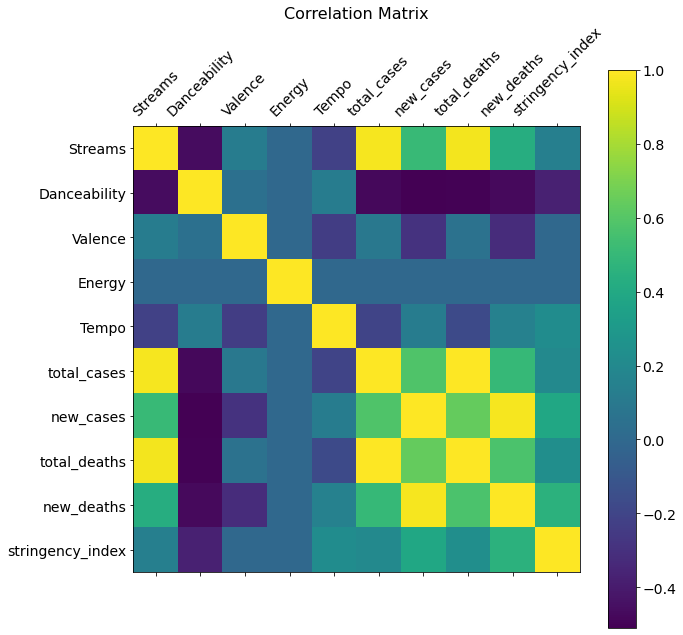

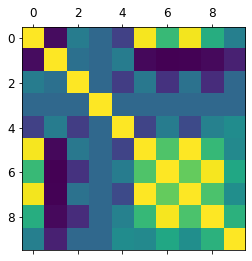

In [37]:

df= india_matrix_corr2020
f = plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
#sn.heatmap(df, annot=True)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.matshow(india_matrix_corr2020.corr())
plt.savefig("output_files/Correlation Matrix.png") 
plt.show()

In [35]:


filtered_corr= country_covid__2020_df.loc[:,["location","date", "new_cases","total_cases","total_deaths","total_deaths","stringency_index"]]



## Merging dataframe of features and covid

covid_and_features_df = pd.merge(country_tracks_data_df,country_covid__2020_groupby, on="Month")




# Merge the dataframes into one nice comparison dataframe to scatter plot

#country_covid_valence_df = pd.merge(country_tracks_data_df_2020, country_covid__2020_groupby, on="Month")

#country_covid_valence_df




#filtered_corr.reset_index()


In [88]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,index,location,date,new_cases,total_cases,total_deaths,total_deaths,stringency_index,Year
0,34665,India,2020-01-30,1.0,1.0,NaN,NaN,10.19,2020
1,34666,India,2020-01-31,0.0,1.0,NaN,NaN,10.19,2020
2,34667,India,2020-02-01,0.0,1.0,NaN,NaN,10.19,2020
3,34668,India,2020-02-02,1.0,2.0,NaN,NaN,10.19,2020
4,34669,India,2020-02-03,1.0,3.0,NaN,NaN,10.19,2020
...,...,...,...,...,...,...,...,...,...
332,34997,India,2020-12-27,20021.0,10207871.0,147901.0,147901.0,68.98,2020
333,34998,India,2020-12-28,16432.0,10224303.0,148153.0,148153.0,68.98,2020
334,34999,India,2020-12-29,20549.0,10244852.0,148439.0,148439.0,68.98,2020
335,35000,India,2020-12-30,21822.0,10266674.0,148738.0,148738.0,68.98,2020


NameError: name 'corr' is not defined

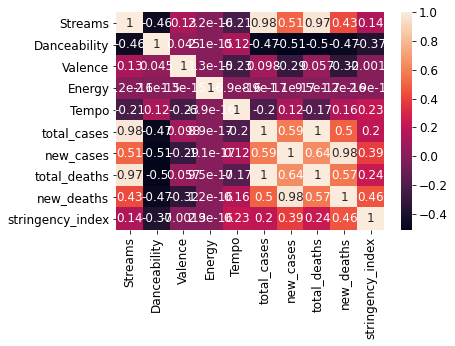

<Figure size 864x576 with 0 Axes>

In [118]:
#corrMatrix = india_matrix_corr2020.corr()
#print(corrMatrix)
#sn.heatmap(corrMatrix, annot=True)
#fig= plt.figure(figsize=(12,8)) 
fig.suptitle('Matrix Correlation ')         # Set up main title
#plt.savefig("output_files/Correlation Matrix.png")    
#corr.style.background_gradient(cmap='coolwarm')
# Save the png file   
#plt.show()


## Continue with Analysis

In [89]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Tempo,New Cases
0,1,22949.615,1.0
1,2,23222.276,2.0
2,3,23197.086,1394.0
3,4,23197.238,33466.0
4,5,22967.031,155746.0
5,6,22587.841,394872.0
6,7,23010.519,1110507.0
7,8,23373.653,1995178.0
8,9,23578.501,2621418.0
9,10,23324.955,1871498.0


In [36]:
# Add a new cases per million column

country_polulation = 67886011  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

NameError: name 'country_covid_valence_df' is not defined

NameError: name 'country_covid_valence_df' is not defined

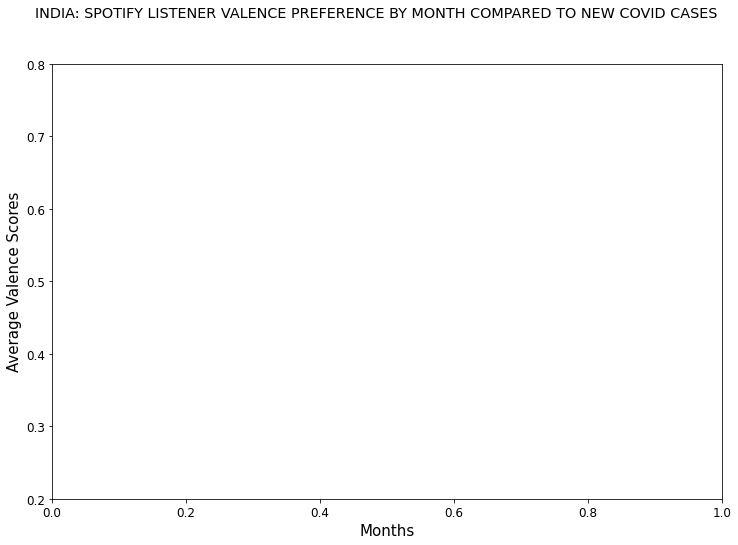

In [37]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('INDIA: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence_Stream%']
ax1.plot(months, ax1_ydata, label="Weighted Avg Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

In [ ]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

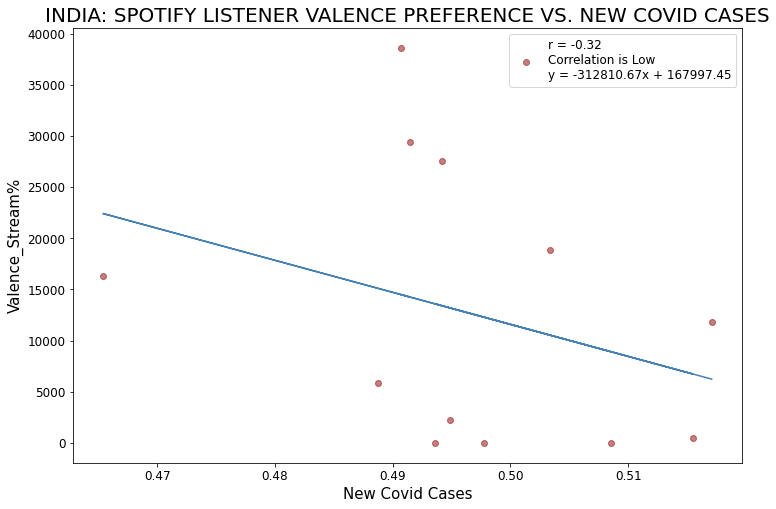

In [70]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence_Stream%']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('INDIA: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence_Stream%")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()